In [1]:
import torch
%matplotlib inline

import os
import gzip
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import clear_output
from datetime import datetime
from torchvision import datasets, transforms

from PIL import Image
from IPython.display import Image 



In [2]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

print(dev)

cuda:0


In [4]:
from torch.utils.data import Dataset, DataLoader
import os
import glob
from PIL import Image
import re


px_size = 60
py_size = 60

class DatasetMSE(Dataset):

    def __init__(self, image_dir, label_dir):
        self.colors = {
            0:torch.FloatTensor([255.0, 0.0, 0.0]),
            1:torch.FloatTensor([127.0, 0.0, 0.0]),
            2:torch.FloatTensor([255.0, 255.0, 0.0]),
            3:torch.FloatTensor([0.0, 255.0, 255.0]),
            4:torch.FloatTensor([0.0, 0.0, 255.0]),
            5:torch.FloatTensor([0.0, 255.0, 0.0])
            }
        
        self.transforms = []
        self.tf = transforms.Compose([transforms.ToTensor(), transforms.Resize((px_size,py_size))])
        self.label_imgs = torch.stack([self.get_labels(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/00*')]).to(dev)
        self.colour = torch.stack([self.get_colour(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/00*')]).to(dev)
        self.input_imgs = torch.stack([(self.tf((Image.open(file)))) for file in glob.glob(image_dir + '/00*')]).to(dev)
        self.add_colour()

    def __len__(self):
        return len(self.input_imgs)


    def __getitem__(self, idx):
        input_img, label_img = self.input_imgs[idx], self.label_imgs[idx]
        return input_img, label_img
    
    def col_sim(self, d):
        d = d*255
        a = torch.FloatTensor([torch.dist(d, self.colors[i]) for i in self.colors])
        return torch.argmin(a) 
    
    def view_shape(self):
        print(self.label_imgs.shape)
        print(self.input_imgs.shape)
    
    def get_labels(self, x):
        new_x = torch.zeros(6,px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[self.col_sim(new_d3[i][j])][i][j] = 1
                
        return new_x
        
    def get_colour(self, x):
        new_x = torch.zeros(px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[i][j] = self.col_sim(new_d3[i][j])
        return new_x
        
    def add_colour(self):
        print(self.input_imgs.shape)
        for i in range(self.input_imgs.shape[0]):
            print(i)
            self.input_imgs[i][0][self.colour[i] == 3] += 0.2
            self.input_imgs[i][1][self.colour[i] == 4] += 0.2
            self.input_imgs[i][2][self.colour[i] == 5] += 0.2
        self.input_imgs = self.input_imgs.clamp(0, 1)
            #new_x[1][y[i]==4] += 0.5
            #new_x[2][y[i]==5] += 0.5
            #new_x[2][y[i] == 0] += 0.5
            #new_x[1][y[i]==0] += 0.5
        
    
    def print_tensor(self, x):
        print(self.input_imgs[x])

In [32]:
dset_mse = DatasetMSE("Original","Labeled")
train_loader_MSE = torch.utils.data.DataLoader(dset_mse, shuffle=True, batch_size=batch_size)
#dset_mse.print_tensor(2)

torch.Size([9, 3, 60, 60])
0
1
2
3
4
5
6
7
8


In [3]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [4]:
def initial_seed(batch_size):
    return torch.zeros(batch_size, 3, px_size, py_size)

# Encode colour classes 1
def to_classes(d):
    d = d*255
    x = torch.zeros(6, d.shape[1], d.shape[2])
    # RED 255,0,0
    x[0][(d[0] > 220) & (d[1] < 20) & (d[2] < 20)] = 1
    # BROWN 127,0,0
    x[1][(d[0] > 60) & (d[0] < 200) & (d[1] < 60) & (d[2] < 60)] = 1
    # YELLOW 255, 255, 0
    x[2][(d[0] > 20) & (d[1] > 30) & (d[2] < 230)] = 1
    # LIGHT BLUE 0,255,255
    x[3][(d[0] < 100) & (d[1] > 100) & (d[2] > 100)] = 1
    # DARK BLUE 0,0,255
    x[4][(d[0] < 30) & (d[1] < 30) & (d[2] > 150)] = 1
    # GREEN 0,255,0
    x[5][(d[0] < 120) & (d[1] > 140) & (d[2] < 160)] = 1
    return torch.FloatTensor(x)

# Encode colour classes 2
def to_class(d):
    d = d*255
    x = torch.zeros(d.shape[1], d.shape[2])
    # RED 255,0,0
    #x[(d[0] > 180) & (d[1] < 60) & (d[2] < 60)] = 0
    # BROWN 127,0,0
    x[(d[0] > 60) & (d[0] < 200) & (d[1] < 60) & (d[2] < 60)] = 1
    # YELLOW 255, 255, 0
    x[(d[0] > 100) & (d[1] > 100) & (d[2] < 100)] = 2
    # LIGHT BLUE 0,255,255
    x[(d[0] < 60) & (d[1] > 180) & (d[2] > 180)] = 3
    # DARK BLUE 0,0,255
    x[(d[0] < 60) & (d[1] < 60) & (d[2] > 180)] = 4
    # GREEN 0,255,0
    x[(d[0] < 70) & (d[1] > 170) & (d[2] < 70)] = 5
    return torch.FloatTensor(x)

colors = {
    0:torch.FloatTensor([255.0, 0.0, 0.0]).to(dev),
    1:torch.FloatTensor([127.0, 0.0, 0.0]).to(dev),
    2:torch.FloatTensor([255.0, 255.0, 0.0]).to(dev),
    3:torch.FloatTensor([0.0, 255.0, 255.0]).to(dev),
    4:torch.FloatTensor([0.0, 0.0, 255.0]).to(dev),
    5:torch.FloatTensor([0.0, 255.0, 0.0]).to(dev)
    }
          
    
# Get RGB class channels
def get_rgb(x):
    return x.transpose(0,1)[3:9].transpose(0,1)

# Transform to display image
ts = transforms.ToPILImage()

# Get max class value and convert to RGB for the C classes
def max_rgb(x):
    newimg = torch.zeros(x.shape[0], px_size, px_size, 3).to(dev)
    for i in range(x.shape[0]):
        # RED 255, 0, 0
        newimg[i][torch.argmax(x[i],dim=0) == 0] = colors[0]
        # BROWN 127 0 0 
        newimg[i][torch.argmax(x[i],dim=0) == 1] = colors[1]
        # YELLOW 255, 255, 0
        newimg[i][torch.argmax(x[i],dim=0) == 2] = colors[2]
        # L BLUE 0, 255, 255
        newimg[i][torch.argmax(x[i],dim=0) == 3] = colors[3]
        # D BLUE 0, 0, 255
        newimg[i][torch.argmax(x[i],dim=0) == 4] = colors[4]
        # GREEN 0, 255, 0
        newimg[i][torch.argmax(x[i],dim=0) == 5] = colors[5]
    
    return (newimg/255.0).transpose(1,3).transpose(2,3)


def max_rgba(x):
    newimg = torch.zeros(px_size, px_size, 3)
    # RED 255, 0, 0
    newimg[torch.argmax(x,dim=0) == 0] = torch.FloatTensor([255.0, 0.0, 0.0])
    # BROWN 127 0 0 
    newimg[torch.argmax(x,dim=0) == 1] = torch.FloatTensor([127.0, 0.0, 0.0])
    # YELLOW 255, 255, 0
    newimg[torch.argmax(x,dim=0) == 2] = torch.FloatTensor([255.0, 255.0, 0.0])
    # L BLUE 0, 255, 255
    newimg[torch.argmax(x,dim=0) == 3] = torch.FloatTensor([0.0, 255.0, 255.0])
    # D BLUE 0, 0, 255
    newimg[torch.argmax(x,dim=0) == 4] = torch.FloatTensor([0.0, 0.0, 255.0])
    # GREEN 0, 255, 0
    newimg[torch.argmax(x,dim=0) == 5] = torch.FloatTensor([0.0, 255.0, 0.0])
    
    alpha = torch.max(x, dim=0).values.to(dev)
    #alpha = alpha/torch.max(alpha)
    newimg = (newimg/255.0).to(dev)
    newimg = torch.cat((newimg, alpha.view(px_size, px_size, 1)), dim=2)
    print(newimg.shape)
    return newimg.transpose(0,2).transpose(1,2)

# Flatten dimension
def loss_classes(x):
    y = torch.flatten(x,1,2)
    return y


In [ ]:
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, labels = next(iter(train_loader_CE))
# Make a grid from batch
out = torchvision.utils.make_grid(torch.cat((inputs, max_rgb(labels)),dim=0), nrow=batch_size)
imshow(out, title="Sample Batch (Image and Ground Truth)")


In [5]:
batch_size = 10

In [6]:
# Cross Entropy

from torch.utils.data import Dataset, DataLoader
import os
import glob
from PIL import Image


px_size = 60
py_size = 60

class DatasetCE(Dataset):

    def __init__(self, image_dir, label_dir):
        self.colors = {
            0:torch.FloatTensor([255.0, 0.0, 0.0]),
            1:torch.FloatTensor([127.0, 0.0, 0.0]),
            2:torch.FloatTensor([255.0, 255.0, 0.0]),
            3:torch.FloatTensor([0.0, 255.0, 255.0]),
            4:torch.FloatTensor([0.0, 0.0, 255.0]),
            5:torch.FloatTensor([0.0, 255.0, 0.0])
            }
        
        self.transforms = []
        self.tf = transforms.Compose([transforms.ToTensor(), transforms.Resize((px_size,py_size))])
        self.input_imgs = torch.stack([self.tf((Image.open(file))) for file in glob.glob(image_dir + '/*')]).to(dev)
        self.label_imgs = torch.stack([self.get_labels(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/*')]).to(dev)
        #self.add_colour()
    
    def __len__(self):
        return len(self.input_imgs)


    def __getitem__(self, idx):
        input_img, label_img = self.input_imgs[idx], self.label_imgs[idx]
        return input_img, label_img
    
    def col_sim(self, d):
        d = d*255
        a = torch.FloatTensor([torch.dist(d, self.colors[i]) for i in self.colors])
        return torch.argmin(a) 
    
    def view_shape(self):
        print(self.label_imgs.shape)
        print(self.input_imgs.shape)
    
    # (3, x, y)
    def get_labels(self, x):
        new_x = torch.zeros(px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[i][j] = self.col_sim(new_d3[i][j])
        return new_x
    
    def add_colour(self):
        y = self.label_imgs.clone().detach()
        for i in range(self.input_imgs.shape[0]):
            self.input_imgs[i][0][y[i] == 3] += 0.3
            self.input_imgs[i][1][y[i] == 4] += 0.3
            self.input_imgs[i][2][y[i] == 5] += 0.3
        self.input_imgs = self.input_imgs.clamp(0, 1)

    

    

In [7]:
# Cross Entropy

dsetCE = DatasetCE("Original","Labeled")
train_loader_CE = torch.utils.data.DataLoader(dsetCE, shuffle=True, batch_size=batch_size)
dsetCE.__len__()

150

In [8]:
train_DS, test_DS = torch.utils.data.random_split(dsetCE, [120, 30])
train_loader_CE = torch.utils.data.DataLoader(train_DS, shuffle=True, batch_size=batch_size)
test_loader_CE = torch.utils.data.DataLoader(test_DS, shuffle=True, batch_size=1)

In [16]:
# Cellular automata class
class CAModel(nn.Module):

    def __init__(self, channel_n, fire_rate=0.5, device=torch.device("cpu")):
        super(CAModel, self).__init__()

        self.device = device
        self.channel_n = channel_n
        
        self.fire_rate = fire_rate
        self.to(self.device)
        
        #self.conv0 = nn.Conv2d(45, 12, kernel_size=px_size)
        self.conv1a = nn.Conv2d(45, 36, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(45, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2a = nn.Conv2d(36, 16, kernel_size=1)
        self.conv2b = nn.Conv2d(32, 16, kernel_size=1)
        self.conv3a = nn.Conv2d(16, 6, kernel_size=1)
        self.conv3b = nn.Conv2d(16, 6, kernel_size=1)
        
        self.prewitt_x = torch.FloatTensor([[1,0,-1],[1,0,-1],[1,0,-1]]).to(dev)
        self.prewitt_y = torch.FloatTensor([[1,1,1],[0,0,0],[-1,-1,-1]]).to(dev)
        
        self.sobel_x = torch.FloatTensor([[1,0,-1],[2,0,-2],[1,0,-1]]).to(dev)
        self.sobel_y = torch.FloatTensor([[1,2,1],[0,0,0],[-1,-2,-1]]).to(dev)
        
    def perceive(self, x, angle):

        def _perceive_with(x, weight):
            size = weight.shape[0]
            padding = (size-1)/2
            weight = weight.view(1,1,size,size).repeat(self.channel_n, 1, 1, 1)
            return F.conv2d(x, weight, padding=int(padding), groups=self.channel_n)
        
        # 3x3 sobel operators
        wa_1 = self.sobel_x
        wa_2 = self.sobel_y
        wa_3 = self.prewitt_x
        wa_4 = self.prewitt_y
        
        # Normalise these
        wa_1/=torch.sum(torch.abs(wa_1))
        wa_2/=torch.sum(torch.abs(wa_2))
        wa_3/=torch.sum(torch.abs(wa_3))
        wa_4/=torch.sum(torch.abs(wa_4))

        # Apply convolutions with the 4 of these filters
        y1 = _perceive_with(x, wa_1)
        y2 = _perceive_with(x, wa_2)
        y3 = _perceive_with(x, wa_1)
        y4 = _perceive_with(x, wa_2)
        # Concatenate: x (6 channels), 4 sobel filters (6 channels each), max pool (6 channels) = 36 total
        y = torch.cat((x,y1,y2,y3,y4),1)
        return y

    
    def forward(self, steps, x, last=False):
        x = torch.cat((x, torch.zeros(batch_size,6,px_size,px_size).to(dev)), dim=1)
        if last == True:
            epoch_history = []
            for i in range(steps):
                epoch_history.append(x.detach().transpose(0,1)[3:9])
                b0 = self.perceive(x, 0)
                b1 = self.perceive(x, 0)
                #b1 = self.conv0(b0)
                #b10 = torch.zeros(batch_size, 1, px_size, px_size).to(dev) + b1
                #b2 = torch.cat((b0, b10), dim=1)
                b3_a = self.conv3a(self.relu(self.conv2a(self.relu(self.conv1a(b0)))))
                b3_b = self.conv3b(self.relu(self.conv2b(self.relu(self.conv1b(b1)))))
                b4_a = b3_a*mask1
                b4_b = b3_b*mask2
                b3 = b4_a + b4_b
                #b3 = torch.cat((b3_a, b3_b),dim=2)
                c = x.detach().clone()
                stochastic = torch.rand([b3.size(0),b3.size(1),b3.size(2),b3.size(3)])>self.fire_rate
                stochastic = stochastic.float().to(self.device)

                d = b3*stochastic
                e = c.transpose(0,1)[3:9].transpose(0,1) + d
                f = F.softmax(e, dim=1)
                
                x = torch.cat((c.transpose(0,1)[0:3].transpose(0,1),f),dim=1)
                
            return x, epoch_history
                
        else:
            for i in range(steps):
                b0 = self.perceive(x, 0)
                b1 = self.perceive(x, 0)
                #b1 = self.conv0(b0)
                #b10 = torch.zeros(batch_size, 1, px_size, px_size).to(dev) + b1
                #b2 = torch.cat((b0, b10), dim=1)
                b3_a = self.conv3a((self.conv2a(self.relu(self.conv1a(b0)))))
                b3_b = self.conv3b((self.conv2b(self.relu(self.conv1b(b1)))))
                b4_a = b3_a*mask1
                b4_b = b3_b*mask2
                b3 = b4_a + b4_b
                #b3 = torch.cat((b3_a, b3_b),dim=2)
                c = x.detach().clone()
                stochastic = torch.rand([b3.size(0),b3.size(1),b3.size(2),b3.size(3)])>self.fire_rate
                stochastic = stochastic.float().to(self.device)

                d = b3*stochastic
                e = c.transpose(0,1)[3:9].transpose(0,1) + d
                f = F.softmax(e, dim=1)
                
                x = torch.cat((c.transpose(0,1)[0:3].transpose(0,1),f),dim=1)
            return x

In [19]:
# Load model, set loss function, optimizer and scheduler

model = CAModel(9,fire_rate=0.5,device=dev)
#model = torch.load('modelcollab1.pth')
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0014, betas=(0.9, 0.999))
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.999)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [30,60,90], 0.6)
#loss1 = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')

# RED, BROWN, YELLOW, LBLUE, DBLUE, GREEN
w = torch.FloatTensor([2,1, 1.05, 8, 9, 8.8]).to(dev)
loss2 = torch.nn.CrossEntropyLoss(weight=w, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
#loss = torch.nn.KLDivLoss(size_average=None, reduce=None, reduction='mean', log_target=False)
#loss = FocalLoss()
loss_mse = []
loss_ce = []
history = []
epochs = 200

batch_size=10

In [14]:
mask1 = torch.zeros(1,6,60,60).to(dev)
mask2 = torch.zeros(1,6,60,60).to(dev)
k = mask1.shape[2]
for i in range(k):
    for j in range(k):
        mask1[:,:,i,j] = (i + j + 1) % 2
        mask2[:,:,i,j] = (i + j) % 2

In [20]:
mask1 = torch.cuda.FloatTensor(1, 6, 60, 60).uniform_() > 0.5
mask1 = mask1.int()
mask2 = mask1 - torch.ones(1,6,60,60).cuda()


In [ ]:
for epoch in range(epochs):
    i = 0
    last = False
    if epoch == epochs-1:
        last = True
    for batch in train_loader_MSE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(135, inputs, last=last)
        else:
            x = model.forward(135, inputs, last=last)
            
        b = get_rgb(x)
        out = loss1(b,targets)
        print("Loss =", out)
        loss_mse.append(float(out))
        c = b.detach().clone()
        if (i % 5 == 0):
            print("EPOCH: ", epoch)
            display(ts(max_rgb(c)[0]))
            del c
            
        i += 1
        optimizer.zero_grad()
        out.backward()
        optimizer.step()

In [19]:
torch.save(model, 'modelMSE.pth')

In [25]:
from array2gif import write_gif
eh = [(max_rgb(epoch_history[i])[1]*255).cpu().detach().numpy() for i in range(len(epoch_history))]
#eh = [(max_rgb(epoch_history[i][0])*255).cpu().detach().numpy() for i in range(len(epoch_history))]

write_gif(eh, 'final.gif', fps=1)
#eh[0].shape
#torch.stack(epoch_history)[0].shape

Loss = tensor(1.7892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


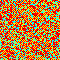

Learning rate:  0.0014
Loss = tensor(1.7890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7866, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


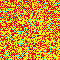

Learning rate:  0.0014
Loss = tensor(1.7827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


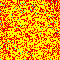

Learning rate:  0.0014
Loss = tensor(1.7708, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


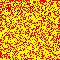

Learning rate:  0.0014
Loss = tensor(1.7647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7651, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


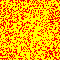

Learning rate:  0.0014
Loss = tensor(1.7570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7428, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7354, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


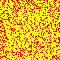

Learning rate:  0.0014
Loss = tensor(1.7335, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7252, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


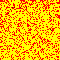

Learning rate:  0.0014
Loss = tensor(1.7286, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7307, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7202, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7241, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7264, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


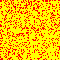

Learning rate:  0.0014
Loss = tensor(1.7168, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7078, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7265, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


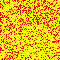

Learning rate:  0.0014
Loss = tensor(1.7170, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


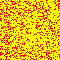

Learning rate:  0.0014
Loss = tensor(1.7243, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7095, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7016, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


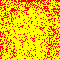

Learning rate:  0.0014
Loss = tensor(1.7130, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6952, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


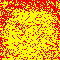

Learning rate:  0.0014
Loss = tensor(1.6960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


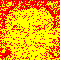

Learning rate:  0.0014
Loss = tensor(1.6774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


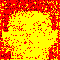

Learning rate:  0.0014
Loss = tensor(1.6594, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6612, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


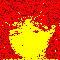

Learning rate:  0.0014
Loss = tensor(1.6635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


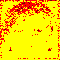

Learning rate:  0.0014
Loss = tensor(1.6361, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6273, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6428, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6338, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


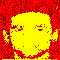

Learning rate:  0.0014
Loss = tensor(1.6375, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6069, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6377, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


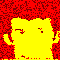

Learning rate:  0.0014
Loss = tensor(1.6070, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6143, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


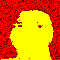

Learning rate:  0.0014
Loss = tensor(1.6135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6247, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6126, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6217, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


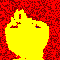

Learning rate:  0.0014
Loss = tensor(1.6088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6173, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6100, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6004, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


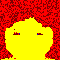

Learning rate:  0.0014
Loss = tensor(1.5901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


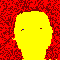

Learning rate:  0.0014
Loss = tensor(1.6103, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6233, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6225, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5864, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


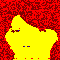

Learning rate:  0.0014
Loss = tensor(1.6034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5881, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


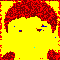

Learning rate:  0.0014
Loss = tensor(1.5800, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


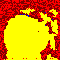

Learning rate:  0.0014
Loss = tensor(1.5943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5712, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6179, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5798, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


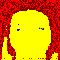

Learning rate:  0.0014
Loss = tensor(1.5685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5631, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6060, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5630, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


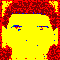

Learning rate:  0.0014
Loss = tensor(1.5730, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5772, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


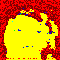

Learning rate:  0.0014
Loss = tensor(1.5915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


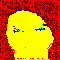

Learning rate:  0.0014
Loss = tensor(1.5531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


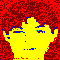

Learning rate:  0.0014
Loss = tensor(1.5458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


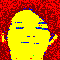

Learning rate:  0.0014
Loss = tensor(1.5369, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5672, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5396, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


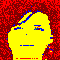

Learning rate:  0.0014
Loss = tensor(1.5329, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5380, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5327, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


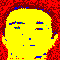

Learning rate:  0.0014
Loss = tensor(1.5327, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5340, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


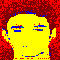

Learning rate:  0.0014
Loss = tensor(1.5292, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5245, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5190, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


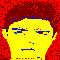

Learning rate:  0.0014
Loss = tensor(1.5298, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5362, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5192, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


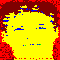

Learning rate:  0.0014
Loss = tensor(1.5294, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5008, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


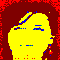

Learning rate:  0.0014
Loss = tensor(1.4985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5137, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


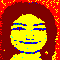

Learning rate:  0.0014
Loss = tensor(1.5051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5169, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


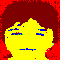

Learning rate:  0.0014
Loss = tensor(1.5123, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


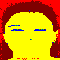

Learning rate:  0.0014
Loss = tensor(1.5010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5012, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


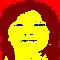

Learning rate:  0.0014
Loss = tensor(1.4767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


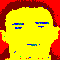

Learning rate:  0.0014
Loss = tensor(1.4980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


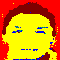

Learning rate:  0.0014
Loss = tensor(1.4929, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


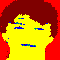

Learning rate:  0.0014
Loss = tensor(1.5080, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


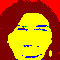

Learning rate:  0.0014
Loss = tensor(1.4897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4739, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


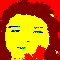

Learning rate:  0.0014
Loss = tensor(1.5106, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5114, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4883, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


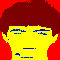

Learning rate:  0.0014
Loss = tensor(1.4802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4875, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


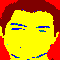

Learning rate:  0.0014
Loss = tensor(1.4702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


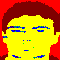

Learning rate:  0.0014
Loss = tensor(1.4806, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4936, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4757, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


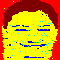

Learning rate:  0.0014
Loss = tensor(1.4720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4621, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4691, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


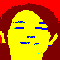

Learning rate:  0.0014
Loss = tensor(1.4897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


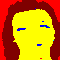

Learning rate:  0.0014
Loss = tensor(1.4680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4616, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5092, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


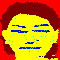

Learning rate:  0.0014
Loss = tensor(1.4621, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4726, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


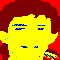

Learning rate:  0.0014
Loss = tensor(1.4698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


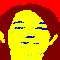

Learning rate:  0.0014
Loss = tensor(1.4876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


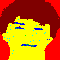

Learning rate:  0.0014
Loss = tensor(1.4776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4691, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4778, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


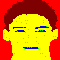

Learning rate:  0.0014
Loss = tensor(1.4869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


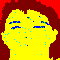

Learning rate:  0.0014
Loss = tensor(1.4586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4877, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


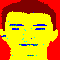

Learning rate:  0.0014
Loss = tensor(1.4829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


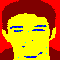

Learning rate:  0.0014
Loss = tensor(1.4564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4700, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


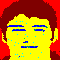

Learning rate:  0.0014
Loss = tensor(1.4671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4793, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


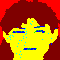

Learning rate:  0.0014
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5026, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


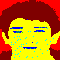

Learning rate:  0.0014
Loss = tensor(1.4540, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


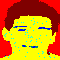

Learning rate:  0.0014
Loss = tensor(1.4659, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


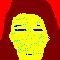

Learning rate:  0.0014
Loss = tensor(1.4616, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


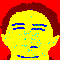

Learning rate:  0.0014
Loss = tensor(1.4750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


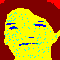

Learning rate:  0.0014
Loss = tensor(1.4687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


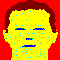

Learning rate:  0.0014
Loss = tensor(1.4598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4705, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


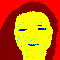

Learning rate:  0.0014
Loss = tensor(1.4780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


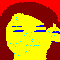

Learning rate:  0.0014
Loss = tensor(1.4673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


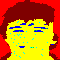

Learning rate:  0.0014
Loss = tensor(1.4656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4852, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


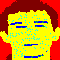

Learning rate:  0.0014
Loss = tensor(1.4575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


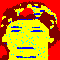

Learning rate:  0.0014
Loss = tensor(1.5053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4487, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


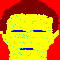

Learning rate:  0.0014
Loss = tensor(1.4893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


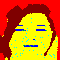

Learning rate:  0.0014
Loss = tensor(1.4624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


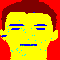

Learning rate:  0.0014
Loss = tensor(1.4581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4891, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4429, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


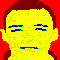

Learning rate:  0.0014
Loss = tensor(1.4913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4667, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


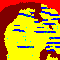

Learning rate:  0.0014
Loss = tensor(1.4803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


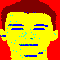

Learning rate:  0.0014
Loss = tensor(1.4780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4574, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4963, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


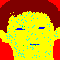

Learning rate:  0.0014
Loss = tensor(1.4757, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4574, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4612, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


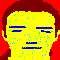

Learning rate:  0.0014
Loss = tensor(1.4753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


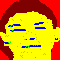

Learning rate:  0.0014
Loss = tensor(1.4547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4446, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


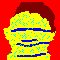

Learning rate:  0.0014
Loss = tensor(1.4606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5060, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4674, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


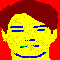

Learning rate:  0.0014
Loss = tensor(1.4616, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4452, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


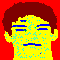

Learning rate:  0.0014
Loss = tensor(1.4817, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


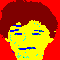

Learning rate:  0.0014
Loss = tensor(1.4496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4955, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4491, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


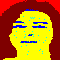

Learning rate:  0.0014
Loss = tensor(1.4702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


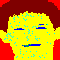

Learning rate:  0.0014
Loss = tensor(1.4681, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4574, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4494, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


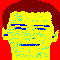

Learning rate:  0.0014
Loss = tensor(1.4543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5115, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4600, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


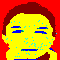

Learning rate:  0.0014
Loss = tensor(1.4637, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


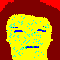

Learning rate:  0.0008399999999999999
Loss = tensor(1.4537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4628, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4637, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


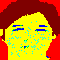

Learning rate:  0.0008399999999999999
Loss = tensor(1.4689, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4574, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


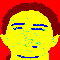

Learning rate:  0.0008399999999999999
Loss = tensor(1.4374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


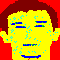

Learning rate:  0.0008399999999999999
Loss = tensor(1.4390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


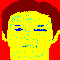

Learning rate:  0.0008399999999999999
Loss = tensor(1.4683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4966, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4482, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4494, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


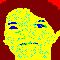

Learning rate:  0.0008399999999999999
Loss = tensor(1.4665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


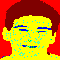

Learning rate:  0.0008399999999999999
Loss = tensor(1.4753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4410, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4567, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


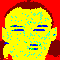

Learning rate:  0.0008399999999999999
Loss = tensor(1.4655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4621, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


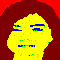

Learning rate:  0.0008399999999999999
Loss = tensor(1.4416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


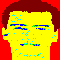

Learning rate:  0.0008399999999999999
Loss = tensor(1.4475, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4417, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4487, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4903, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


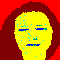

Learning rate:  0.0008399999999999999
Loss = tensor(1.4581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4465, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4487, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4800, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


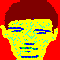

Learning rate:  0.0008399999999999999
Loss = tensor(1.4646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


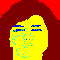

Learning rate:  0.0008399999999999999
Loss = tensor(1.4698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4595, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4259, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4428, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


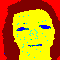

Learning rate:  0.0008399999999999999
Loss = tensor(1.4860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4388, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


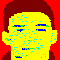

Learning rate:  0.0008399999999999999
Loss = tensor(1.4521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


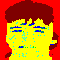

Learning rate:  0.0008399999999999999
Loss = tensor(1.4561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4385, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


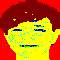

Learning rate:  0.0008399999999999999
Loss = tensor(1.4441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


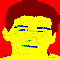

Learning rate:  0.0008399999999999999
Loss = tensor(1.4402, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4286, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


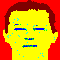

Learning rate:  0.0008399999999999999
Loss = tensor(1.4416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4540, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


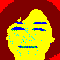

Learning rate:  0.0008399999999999999
Loss = tensor(1.4582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4631, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


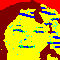

Learning rate:  0.0008399999999999999
Loss = tensor(1.4588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4410, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


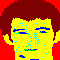

Learning rate:  0.0008399999999999999
Loss = tensor(1.4436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


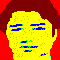

Learning rate:  0.0008399999999999999
Loss = tensor(1.4558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4595, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


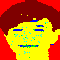

Learning rate:  0.0008399999999999999
Loss = tensor(1.4813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4454, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  38


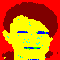

Learning rate:  0.0008399999999999999
Loss = tensor(1.4281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  38


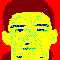

Learning rate:  0.0008399999999999999
Loss = tensor(1.4481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  38


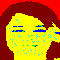

Learning rate:  0.0008399999999999999
Loss = tensor(1.4480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  39


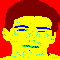

Learning rate:  0.0008399999999999999
Loss = tensor(1.4517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  39


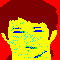

Learning rate:  0.0008399999999999999
Loss = tensor(1.4545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4430, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4438, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4443, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  39


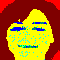

Learning rate:  0.0008399999999999999
Loss = tensor(1.4459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4321, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  40


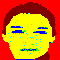

Learning rate:  0.0008399999999999999
Loss = tensor(1.4366, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4398, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  40


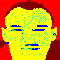

Learning rate:  0.0008399999999999999
Loss = tensor(1.4808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4427, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4883, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  40


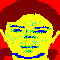

Learning rate:  0.0008399999999999999
Loss = tensor(1.4422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  41


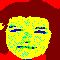

Learning rate:  0.0008399999999999999
Loss = tensor(1.4404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4424, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  41


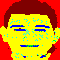

Learning rate:  0.0008399999999999999
Loss = tensor(1.4552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4428, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4329, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  41


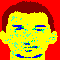

Learning rate:  0.0008399999999999999
Loss = tensor(1.4505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4419, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  42


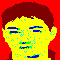

Learning rate:  0.0008399999999999999
Loss = tensor(1.4468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4381, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4357, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  42


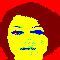

Learning rate:  0.0008399999999999999
Loss = tensor(1.4311, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4465, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4503, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  42


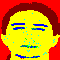

Learning rate:  0.0008399999999999999
Loss = tensor(1.4236, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  43


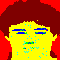

Learning rate:  0.0008399999999999999
Loss = tensor(1.4491, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4446, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4333, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  43


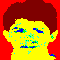

Learning rate:  0.0008399999999999999
Loss = tensor(1.4483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4232, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4207, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  43


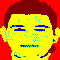

Learning rate:  0.0008399999999999999
Loss = tensor(1.4423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4368, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  44


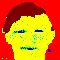

Learning rate:  0.0008399999999999999
Loss = tensor(1.4856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4322, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4347, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4461, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  44


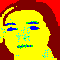

Learning rate:  0.0008399999999999999
Loss = tensor(1.4311, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4306, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4219, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  44


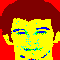

Learning rate:  0.0008399999999999999
Loss = tensor(1.4473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  45


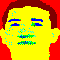

Learning rate:  0.0008399999999999999
Loss = tensor(1.4441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4312, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4515, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  45


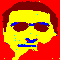

Learning rate:  0.0008399999999999999
Loss = tensor(1.4670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4304, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4396, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  45


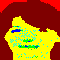

Learning rate:  0.0008399999999999999
Loss = tensor(1.4282, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  46


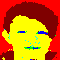

Learning rate:  0.0008399999999999999
Loss = tensor(1.4310, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4348, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4179, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  46


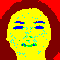

Learning rate:  0.0008399999999999999
Loss = tensor(1.4237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4224, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4304, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4120, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  46


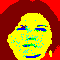

Learning rate:  0.0008399999999999999
Loss = tensor(1.4248, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  47


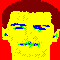

Learning rate:  0.0008399999999999999
Loss = tensor(1.4183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4330, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  47


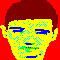

Learning rate:  0.0008399999999999999
Loss = tensor(1.4356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4162, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4125, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4572, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  47


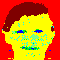

Learning rate:  0.0008399999999999999
Loss = tensor(1.4280, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  48


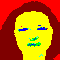

Learning rate:  0.0008399999999999999
Loss = tensor(1.4239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4338, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4118, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4292, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  48


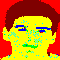

Learning rate:  0.0008399999999999999
Loss = tensor(1.4466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4402, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4194, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4361, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4207, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  48


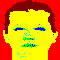

Learning rate:  0.0008399999999999999
Loss = tensor(1.4315, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  49


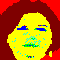

Learning rate:  0.0008399999999999999
Loss = tensor(1.4218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4189, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4361, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4189, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4160, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  49


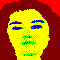

Learning rate:  0.0008399999999999999
Loss = tensor(1.4128, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4287, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4267, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4320, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  49


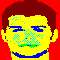

Learning rate:  0.0008399999999999999
Loss = tensor(1.4409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  50


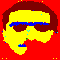

Learning rate:  0.0008399999999999999
Loss = tensor(1.4191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4231, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4164, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  50


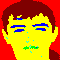

Learning rate:  0.0008399999999999999
Loss = tensor(1.4137, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4174, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4155, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4078, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4194, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  50


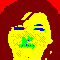

Learning rate:  0.0008399999999999999
Loss = tensor(1.4204, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  51


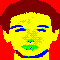

Learning rate:  0.0008399999999999999
Loss = tensor(1.4376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4162, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4242, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  51


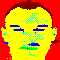

Learning rate:  0.0008399999999999999
Loss = tensor(1.4115, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4338, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4220, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  51


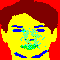

Learning rate:  0.0008399999999999999
Loss = tensor(1.4401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  52


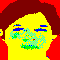

Learning rate:  0.0008399999999999999
Loss = tensor(1.4209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4097, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4213, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  52


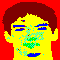

Learning rate:  0.0008399999999999999
Loss = tensor(1.4205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4299, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4189, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  52


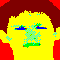

Learning rate:  0.0008399999999999999
Loss = tensor(1.4112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  53


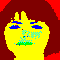

Learning rate:  0.0008399999999999999
Loss = tensor(1.4206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4282, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4162, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4055, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  53


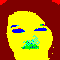

Learning rate:  0.0008399999999999999
Loss = tensor(1.4055, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4275, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4208, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  53


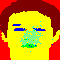

Learning rate:  0.0008399999999999999
Loss = tensor(1.4362, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4180, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  54


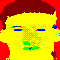

Learning rate:  0.0008399999999999999
Loss = tensor(1.4191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4136, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4091, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  54


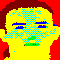

Learning rate:  0.0008399999999999999
Loss = tensor(1.4054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4316, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  54


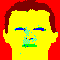

Learning rate:  0.0008399999999999999
Loss = tensor(1.4008, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  55


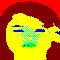

Learning rate:  0.0008399999999999999
Loss = tensor(1.4023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4247, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  55


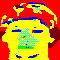

Learning rate:  0.0008399999999999999
Loss = tensor(1.4391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4072, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  55


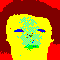

Learning rate:  0.0008399999999999999
Loss = tensor(1.4213, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4400, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  56


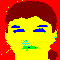

Learning rate:  0.0008399999999999999
Loss = tensor(1.4314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3957, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4040, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  56


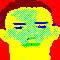

Learning rate:  0.0008399999999999999
Loss = tensor(1.4045, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4143, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  56


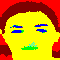

Learning rate:  0.0008399999999999999
Loss = tensor(1.4106, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4241, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  57


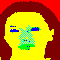

Learning rate:  0.0008399999999999999
Loss = tensor(1.3790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4222, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4067, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  57


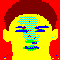

Learning rate:  0.0008399999999999999
Loss = tensor(1.4316, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4294, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  57


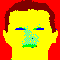

Learning rate:  0.0008399999999999999
Loss = tensor(1.4224, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  58


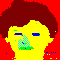

Learning rate:  0.0008399999999999999
Loss = tensor(1.4025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  58


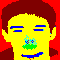

Learning rate:  0.0008399999999999999
Loss = tensor(1.4237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4101, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  58


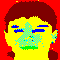

Learning rate:  0.0008399999999999999
Loss = tensor(1.4123, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  59


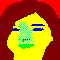

Learning rate:  0.0008399999999999999
Loss = tensor(1.4103, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4269, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4117, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  59


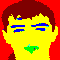

Learning rate:  0.0008399999999999999
Loss = tensor(1.4301, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4163, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4114, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  59


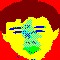

Learning rate:  0.0008399999999999999
Loss = tensor(1.3908, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4157, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  60


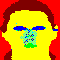

Learning rate:  0.0005039999999999999
Loss = tensor(1.3799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3757, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  60


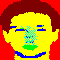

Learning rate:  0.0005039999999999999
Loss = tensor(1.4068, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4029, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4137, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  60


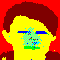

Learning rate:  0.0005039999999999999
Loss = tensor(1.3914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4090, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  61


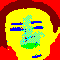

Learning rate:  0.0005039999999999999
Loss = tensor(1.3845, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4079, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4254, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  61


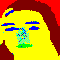

Learning rate:  0.0005039999999999999
Loss = tensor(1.4229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4115, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4092, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  61


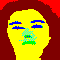

Learning rate:  0.0005039999999999999
Loss = tensor(1.4111, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  62


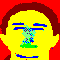

Learning rate:  0.0005039999999999999
Loss = tensor(1.4076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  62


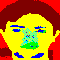

Learning rate:  0.0005039999999999999
Loss = tensor(1.3689, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4231, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4156, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3755, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  62


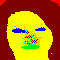

Learning rate:  0.0005039999999999999
Loss = tensor(1.3977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4162, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  63


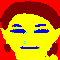

Learning rate:  0.0005039999999999999
Loss = tensor(1.3902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4127, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3891, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  63


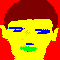

Learning rate:  0.0005039999999999999
Loss = tensor(1.4076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3956, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4280, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4242, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  63


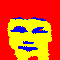

Learning rate:  0.0005039999999999999
Loss = tensor(1.3823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  64


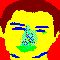

Learning rate:  0.0005039999999999999
Loss = tensor(1.4105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3817, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  64


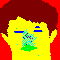

Learning rate:  0.0005039999999999999
Loss = tensor(1.4310, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4128, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4222, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  64


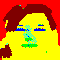

Learning rate:  0.0005039999999999999
Loss = tensor(1.4151, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  65


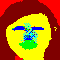

Learning rate:  0.0005039999999999999
Loss = tensor(1.3910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  65


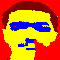

Learning rate:  0.0005039999999999999
Loss = tensor(1.3966, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  65


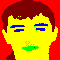

Learning rate:  0.0005039999999999999
Loss = tensor(1.4345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  66


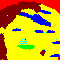

Learning rate:  0.0005039999999999999
Loss = tensor(1.3808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4284, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4107, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  66


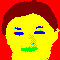

Learning rate:  0.0005039999999999999
Loss = tensor(1.3832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4107, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3966, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4291, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  66


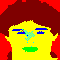

Learning rate:  0.0005039999999999999
Loss = tensor(1.3865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3962, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  67


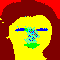

Learning rate:  0.0005039999999999999
Loss = tensor(1.3803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4090, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  67


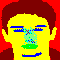

Learning rate:  0.0005039999999999999
Loss = tensor(1.3938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4150, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4228, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4060, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  67


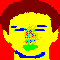

Learning rate:  0.0005039999999999999
Loss = tensor(1.4011, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4003, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  68


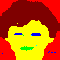

Learning rate:  0.0005039999999999999
Loss = tensor(1.4060, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4021, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4177, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4384, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  68


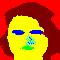

Learning rate:  0.0005039999999999999
Loss = tensor(1.4081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4047, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3898, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  68


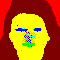

Learning rate:  0.0005039999999999999
Loss = tensor(1.3890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  69


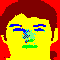

Learning rate:  0.0005039999999999999
Loss = tensor(1.4115, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4078, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4169, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  69


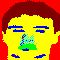

Learning rate:  0.0005039999999999999
Loss = tensor(1.4011, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4044, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4160, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4253, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  69


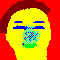

Learning rate:  0.0005039999999999999
Loss = tensor(1.3885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  70


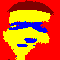

Learning rate:  0.0005039999999999999
Loss = tensor(1.3975, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4117, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4047, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4042, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  70


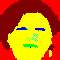

Learning rate:  0.0005039999999999999
Loss = tensor(1.3860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4079, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4248, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4168, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  70


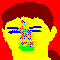

Learning rate:  0.0005039999999999999
Loss = tensor(1.4443, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  71


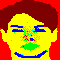

Learning rate:  0.0005039999999999999
Loss = tensor(1.4107, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  71


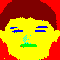

Learning rate:  0.0005039999999999999
Loss = tensor(1.4108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  71


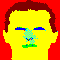

Learning rate:  0.0005039999999999999
Loss = tensor(1.4214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  72


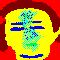

Learning rate:  0.0005039999999999999
Loss = tensor(1.4019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4369, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4157, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  72


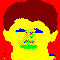

Learning rate:  0.0005039999999999999
Loss = tensor(1.4339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  72


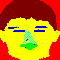

Learning rate:  0.0005039999999999999
Loss = tensor(1.3802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  73


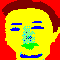

Learning rate:  0.0005039999999999999
Loss = tensor(1.3974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4190, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  73


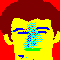

Learning rate:  0.0005039999999999999
Loss = tensor(1.3889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4143, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4040, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  73


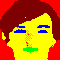

Learning rate:  0.0005039999999999999
Loss = tensor(1.3821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  74


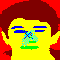

Learning rate:  0.0005039999999999999
Loss = tensor(1.4031, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3793, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4300, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3903, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  74


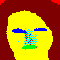

Learning rate:  0.0005039999999999999
Loss = tensor(1.3835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4102, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  74


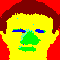

Learning rate:  0.0005039999999999999
Loss = tensor(1.4186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4026, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  75


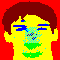

Learning rate:  0.0005039999999999999
Loss = tensor(1.3873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4055, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4207, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  75


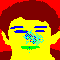

Learning rate:  0.0005039999999999999
Loss = tensor(1.3957, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  75


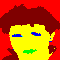

Learning rate:  0.0005039999999999999
Loss = tensor(1.4344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  76


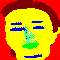

Learning rate:  0.0005039999999999999
Loss = tensor(1.4089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4171, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4101, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  76


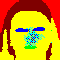

Learning rate:  0.0005039999999999999
Loss = tensor(1.4145, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  76


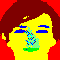

Learning rate:  0.0005039999999999999
Loss = tensor(1.4040, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  77


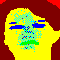

Learning rate:  0.0005039999999999999
Loss = tensor(1.3830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3631, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4323, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  77


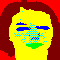

Learning rate:  0.0005039999999999999
Loss = tensor(1.3739, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4177, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3994, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4353, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  77


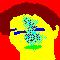

Learning rate:  0.0005039999999999999
Loss = tensor(1.3836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  78


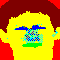

Learning rate:  0.0005039999999999999
Loss = tensor(1.4316, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  78


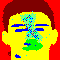

Learning rate:  0.0005039999999999999
Loss = tensor(1.4216, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4006, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  78


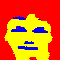

Learning rate:  0.0005039999999999999
Loss = tensor(1.3823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  79


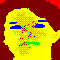

Learning rate:  0.0005039999999999999
Loss = tensor(1.3844, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4264, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4132, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  79


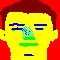

Learning rate:  0.0005039999999999999
Loss = tensor(1.4187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4106, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4091, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4062, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  79


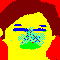

Learning rate:  0.0005039999999999999
Loss = tensor(1.3961, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4021, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  80


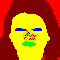

Learning rate:  0.0005039999999999999
Loss = tensor(1.4082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  80


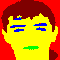

Learning rate:  0.0005039999999999999
Loss = tensor(1.4118, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  80


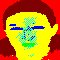

Learning rate:  0.0005039999999999999
Loss = tensor(1.4289, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  81


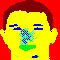

Learning rate:  0.0005039999999999999
Loss = tensor(1.4168, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4256, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  81


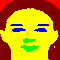

Learning rate:  0.0005039999999999999
Loss = tensor(1.4239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3894, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  81


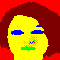

Learning rate:  0.0005039999999999999
Loss = tensor(1.3782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4073, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  82


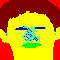

Learning rate:  0.0005039999999999999
Loss = tensor(1.4198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3956, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4189, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  82


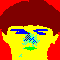

Learning rate:  0.0005039999999999999
Loss = tensor(1.4150, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4059, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4011, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  82


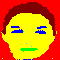

Learning rate:  0.0005039999999999999
Loss = tensor(1.3772, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  83


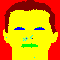

Learning rate:  0.0005039999999999999
Loss = tensor(1.3910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4119, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3844, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  83


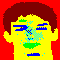

Learning rate:  0.0005039999999999999
Loss = tensor(1.4148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3975, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4103, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3787, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  83


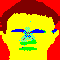

Learning rate:  0.0005039999999999999
Loss = tensor(1.3824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  84


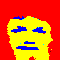

Learning rate:  0.0005039999999999999
Loss = tensor(1.3928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4026, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  84


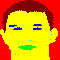

Learning rate:  0.0005039999999999999
Loss = tensor(1.3840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4061, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4288, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  84


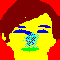

Learning rate:  0.0005039999999999999
Loss = tensor(1.4080, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  85


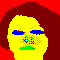

Learning rate:  0.0005039999999999999
Loss = tensor(1.4218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3898, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  85


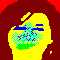

Learning rate:  0.0005039999999999999
Loss = tensor(1.3952, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4253, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4294, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4042, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  85


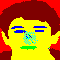

Learning rate:  0.0005039999999999999
Loss = tensor(1.4026, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  86


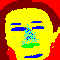

Learning rate:  0.0005039999999999999
Loss = tensor(1.3999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4006, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  86


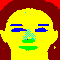

Learning rate:  0.0005039999999999999
Loss = tensor(1.3849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4277, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4388, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  86


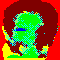

Learning rate:  0.0005039999999999999
Loss = tensor(1.3863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3855, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  87


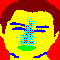

Learning rate:  0.0005039999999999999
Loss = tensor(1.3903, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4221, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  87


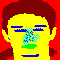

Learning rate:  0.0005039999999999999
Loss = tensor(1.4088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4068, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3894, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  87


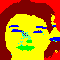

Learning rate:  0.0005039999999999999
Loss = tensor(1.3829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  88


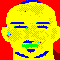

Learning rate:  0.0005039999999999999
Loss = tensor(1.3938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4171, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  88


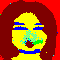

Learning rate:  0.0005039999999999999
Loss = tensor(1.4288, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4050, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4242, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  88


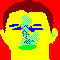

Learning rate:  0.0005039999999999999
Loss = tensor(1.3701, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  89


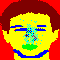

Learning rate:  0.0005039999999999999
Loss = tensor(1.4124, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4021, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  89


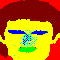

Learning rate:  0.0005039999999999999
Loss = tensor(1.3964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  89


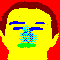

Learning rate:  0.0005039999999999999
Loss = tensor(1.3896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4093, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  90


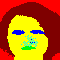

Learning rate:  0.0003023999999999999
Loss = tensor(1.4112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4101, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  90


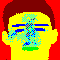

Learning rate:  0.0003023999999999999
Loss = tensor(1.4093, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4078, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  90


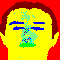

Learning rate:  0.0003023999999999999
Loss = tensor(1.3763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  91


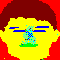

Learning rate:  0.0003023999999999999
Loss = tensor(1.3887, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  91


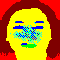

Learning rate:  0.0003023999999999999
Loss = tensor(1.4002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3912, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  91


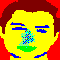

Learning rate:  0.0003023999999999999
Loss = tensor(1.4030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3989, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  92


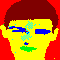

Learning rate:  0.0003023999999999999
Loss = tensor(1.4033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4137, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  92


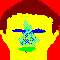

Learning rate:  0.0003023999999999999
Loss = tensor(1.4265, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4059, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  92


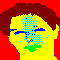

Learning rate:  0.0003023999999999999
Loss = tensor(1.4201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  93


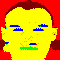

Learning rate:  0.0003023999999999999
Loss = tensor(1.3920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3793, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4164, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3796, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  93


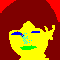

Learning rate:  0.0003023999999999999
Loss = tensor(1.3742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3855, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4125, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  93


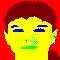

Learning rate:  0.0003023999999999999
Loss = tensor(1.3988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  94


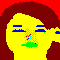

Learning rate:  0.0003023999999999999
Loss = tensor(1.3778, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4012, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  94


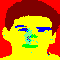

Learning rate:  0.0003023999999999999
Loss = tensor(1.4105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4061, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4302, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4001, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  94


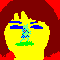

Learning rate:  0.0003023999999999999
Loss = tensor(1.3733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  95


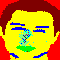

Learning rate:  0.0003023999999999999
Loss = tensor(1.4088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4080, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4092, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  95


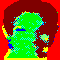

Learning rate:  0.0003023999999999999
Loss = tensor(1.3802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4072, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  95


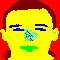

Learning rate:  0.0003023999999999999
Loss = tensor(1.3899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4100, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  96


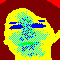

Learning rate:  0.0003023999999999999
Loss = tensor(1.3932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3694, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  96


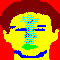

Learning rate:  0.0003023999999999999
Loss = tensor(1.4077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3817, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4092, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  96


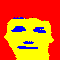

Learning rate:  0.0003023999999999999
Loss = tensor(1.4085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  97


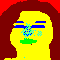

Learning rate:  0.0003023999999999999
Loss = tensor(1.3970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4008, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  97


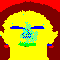

Learning rate:  0.0003023999999999999
Loss = tensor(1.3889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  97


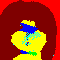

Learning rate:  0.0003023999999999999
Loss = tensor(1.4147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  98


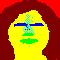

Learning rate:  0.0003023999999999999
Loss = tensor(1.3803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4311, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  98


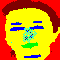

Learning rate:  0.0003023999999999999
Loss = tensor(1.4098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3793, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4028, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  98


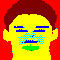

Learning rate:  0.0003023999999999999
Loss = tensor(1.4164, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  99


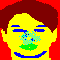

Learning rate:  0.0003023999999999999
Loss = tensor(1.3833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4003, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3875, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  99


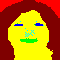

Learning rate:  0.0003023999999999999
Loss = tensor(1.3919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4195, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3883, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  99


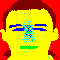

Learning rate:  0.0003023999999999999
Loss = tensor(1.3998, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  100


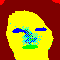

Learning rate:  0.0003023999999999999
Loss = tensor(1.4098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4203, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  100


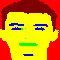

Learning rate:  0.0003023999999999999
Loss = tensor(1.3945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4217, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4038, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  100


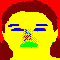

Learning rate:  0.0003023999999999999
Loss = tensor(1.3893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3875, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  101


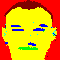

Learning rate:  0.0003023999999999999
Loss = tensor(1.3925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4102, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4035, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  101


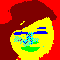

Learning rate:  0.0003023999999999999
Loss = tensor(1.4191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4071, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4079, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  101


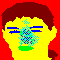

Learning rate:  0.0003023999999999999
Loss = tensor(1.4426, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3975, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  102


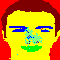

Learning rate:  0.0003023999999999999
Loss = tensor(1.4054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  102


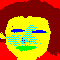

Learning rate:  0.0003023999999999999
Loss = tensor(1.3864, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  102


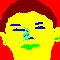

Learning rate:  0.0003023999999999999
Loss = tensor(1.4045, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3784, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  103


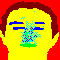

Learning rate:  0.0003023999999999999
Loss = tensor(1.4235, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4072, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  103


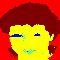

Learning rate:  0.0003023999999999999
Loss = tensor(1.4079, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3976, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  103


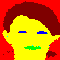

Learning rate:  0.0003023999999999999
Loss = tensor(1.4082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  104


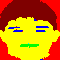

Learning rate:  0.0003023999999999999
Loss = tensor(1.3941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3796, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3961, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  104


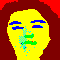

Learning rate:  0.0003023999999999999
Loss = tensor(1.4160, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4294, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4062, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  104


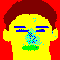

Learning rate:  0.0003023999999999999
Loss = tensor(1.3844, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4111, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  105


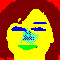

Learning rate:  0.0003023999999999999
Loss = tensor(1.4104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4069, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3881, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  105


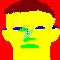

Learning rate:  0.0003023999999999999
Loss = tensor(1.4281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3883, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4020, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  105


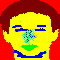

Learning rate:  0.0003023999999999999
Loss = tensor(1.3841, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  106


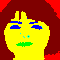

Learning rate:  0.0003023999999999999
Loss = tensor(1.4165, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4134, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3881, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4043, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  106


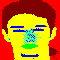

Learning rate:  0.0003023999999999999
Loss = tensor(1.3846, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  106


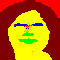

Learning rate:  0.0003023999999999999
Loss = tensor(1.4284, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4207, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  107


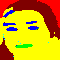

Learning rate:  0.0003023999999999999
Loss = tensor(1.4040, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4073, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3861, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4574, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  107


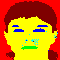

Learning rate:  0.0003023999999999999
Loss = tensor(1.3917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  107


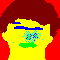

Learning rate:  0.0003023999999999999
Loss = tensor(1.3979, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  108


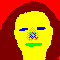

Learning rate:  0.0003023999999999999
Loss = tensor(1.3913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4125, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  108


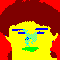

Learning rate:  0.0003023999999999999
Loss = tensor(1.4364, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3933, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4012, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4170, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  108


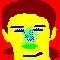

Learning rate:  0.0003023999999999999
Loss = tensor(1.3620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  109


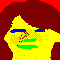

Learning rate:  0.0003023999999999999
Loss = tensor(1.3948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3798, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  109


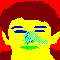

Learning rate:  0.0003023999999999999
Loss = tensor(1.4137, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4049, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4071, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4078, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  109


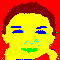

Learning rate:  0.0003023999999999999
Loss = tensor(1.4031, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4052, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  110


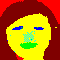

Learning rate:  0.0003023999999999999
Loss = tensor(1.4088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4211, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3918, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  110


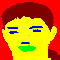

Learning rate:  0.0003023999999999999
Loss = tensor(1.4000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4272, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  110


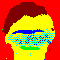

Learning rate:  0.0003023999999999999
Loss = tensor(1.4158, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  111


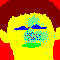

Learning rate:  0.0003023999999999999
Loss = tensor(1.4188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3996, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  111


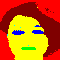

Learning rate:  0.0003023999999999999
Loss = tensor(1.4286, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4113, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4097, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4102, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  111


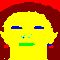

Learning rate:  0.0003023999999999999
Loss = tensor(1.4015, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4003, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  112


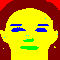

Learning rate:  0.0003023999999999999
Loss = tensor(1.4140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3800, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3837, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  112


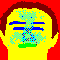

Learning rate:  0.0003023999999999999
Loss = tensor(1.3848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  112


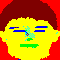

Learning rate:  0.0003023999999999999
Loss = tensor(1.4349, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  113


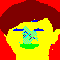

Learning rate:  0.0003023999999999999
Loss = tensor(1.3862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  113


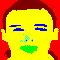

Learning rate:  0.0003023999999999999
Loss = tensor(1.3842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3877, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  113


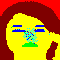

Learning rate:  0.0003023999999999999
Loss = tensor(1.4126, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3887, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  114


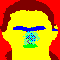

Learning rate:  0.0003023999999999999
Loss = tensor(1.3828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4102, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4127, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  114


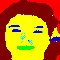

Learning rate:  0.0003023999999999999
Loss = tensor(1.4345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4118, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4204, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  114


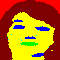

Learning rate:  0.0003023999999999999
Loss = tensor(1.3897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  115


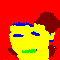

Learning rate:  0.0003023999999999999
Loss = tensor(1.3930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  115


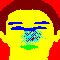

Learning rate:  0.0003023999999999999
Loss = tensor(1.4260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4419, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4200, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  115


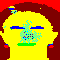

Learning rate:  0.0003023999999999999
Loss = tensor(1.4029, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  116


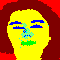

Learning rate:  0.0003023999999999999
Loss = tensor(1.4042, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4021, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  116


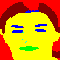

Learning rate:  0.0003023999999999999
Loss = tensor(1.4218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4050, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  116


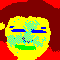

Learning rate:  0.0003023999999999999
Loss = tensor(1.4019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  117


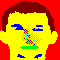

Learning rate:  0.0003023999999999999
Loss = tensor(1.4023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4062, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4332, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  117


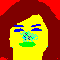

Learning rate:  0.0003023999999999999
Loss = tensor(1.3589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4179, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3837, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  117


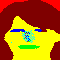

Learning rate:  0.0003023999999999999
Loss = tensor(1.3971, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  118


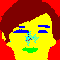

Learning rate:  0.0003023999999999999
Loss = tensor(1.4133, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3962, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4137, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  118


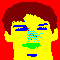

Learning rate:  0.0003023999999999999
Loss = tensor(1.4246, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3864, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  118


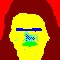

Learning rate:  0.0003023999999999999
Loss = tensor(1.3935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4009, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  119


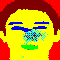

Learning rate:  0.0003023999999999999
Loss = tensor(1.3835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4136, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  119


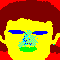

Learning rate:  0.0003023999999999999
Loss = tensor(1.3988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4047, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4150, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  119


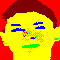

Learning rate:  0.0003023999999999999
Loss = tensor(1.3966, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  120


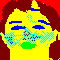

Learning rate:  0.0003023999999999999
Loss = tensor(1.4095, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4011, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3713, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  120


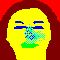

Learning rate:  0.0003023999999999999
Loss = tensor(1.3838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4029, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3784, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  120


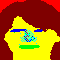

Learning rate:  0.0003023999999999999
Loss = tensor(1.3847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  121


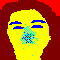

Learning rate:  0.0003023999999999999
Loss = tensor(1.4126, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4384, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  121


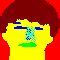

Learning rate:  0.0003023999999999999
Loss = tensor(1.3922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  121


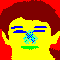

Learning rate:  0.0003023999999999999
Loss = tensor(1.4207, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  122


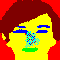

Learning rate:  0.0003023999999999999
Loss = tensor(1.4017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  122


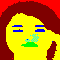

Learning rate:  0.0003023999999999999
Loss = tensor(1.3746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4247, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3991, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  122


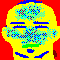

Learning rate:  0.0003023999999999999
Loss = tensor(1.4156, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4028, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  123


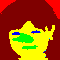

Learning rate:  0.0003023999999999999
Loss = tensor(1.4095, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4096, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4110, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  123


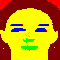

Learning rate:  0.0003023999999999999
Loss = tensor(1.4030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3852, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4028, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  123


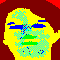

Learning rate:  0.0003023999999999999
Loss = tensor(1.3877, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  124


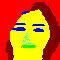

Learning rate:  0.0003023999999999999
Loss = tensor(1.3944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  124


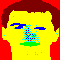

Learning rate:  0.0003023999999999999
Loss = tensor(1.3864, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  124


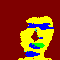

Learning rate:  0.0003023999999999999
Loss = tensor(1.4137, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  125


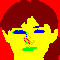

Learning rate:  0.0003023999999999999
Loss = tensor(1.3962, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4086, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  125


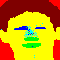

Learning rate:  0.0003023999999999999
Loss = tensor(1.4018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  125


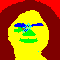

Learning rate:  0.0003023999999999999
Loss = tensor(1.3895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  126


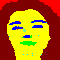

Learning rate:  0.0003023999999999999
Loss = tensor(1.4258, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4100, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4071, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  126


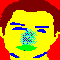

Learning rate:  0.0003023999999999999
Loss = tensor(1.3813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3936, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4163, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4109, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  126


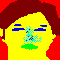

Learning rate:  0.0003023999999999999
Loss = tensor(1.3912, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  127


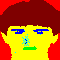

Learning rate:  0.0003023999999999999
Loss = tensor(1.4058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4012, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  127


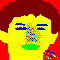

Learning rate:  0.0003023999999999999
Loss = tensor(1.3961, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3903, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  127


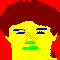

Learning rate:  0.0003023999999999999
Loss = tensor(1.4037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  128


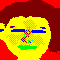

Learning rate:  0.0003023999999999999
Loss = tensor(1.4227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3877, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3957, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4031, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4044, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  128


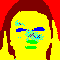

Learning rate:  0.0003023999999999999
Loss = tensor(1.3688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  128


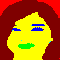

Learning rate:  0.0003023999999999999
Loss = tensor(1.3895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4250, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  129


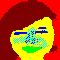

Learning rate:  0.0003023999999999999
Loss = tensor(1.4065, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4052, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4044, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  129


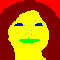

Learning rate:  0.0003023999999999999
Loss = tensor(1.3994, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3841, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4236, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4047, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3778, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  129


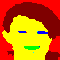

Learning rate:  0.0003023999999999999
Loss = tensor(1.3884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3778, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  130


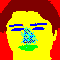

Learning rate:  0.0003023999999999999
Loss = tensor(1.3971, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3751, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4004, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4101, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  130


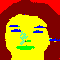

Learning rate:  0.0003023999999999999
Loss = tensor(1.4008, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4127, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  130


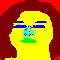

Learning rate:  0.0003023999999999999
Loss = tensor(1.3984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4277, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  131


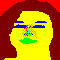

Learning rate:  0.0003023999999999999
Loss = tensor(1.4089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3996, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  131


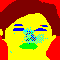

Learning rate:  0.0003023999999999999
Loss = tensor(1.3715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  131


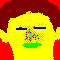

Learning rate:  0.0003023999999999999
Loss = tensor(1.3872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  132


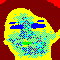

Learning rate:  0.0003023999999999999
Loss = tensor(1.3896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4254, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4387, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  132


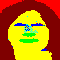

Learning rate:  0.0003023999999999999
Loss = tensor(1.3773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4015, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  132


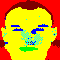

Learning rate:  0.0003023999999999999
Loss = tensor(1.3916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4045, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  133


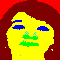

Learning rate:  0.0003023999999999999
Loss = tensor(1.3915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3961, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  133


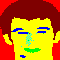

Learning rate:  0.0003023999999999999
Loss = tensor(1.4397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4001, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4127, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  133


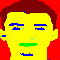

Learning rate:  0.0003023999999999999
Loss = tensor(1.3836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3994, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  134


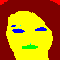

Learning rate:  0.0003023999999999999
Loss = tensor(1.3791, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  134


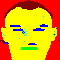

Learning rate:  0.0003023999999999999
Loss = tensor(1.4354, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3908, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  134


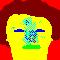

Learning rate:  0.0003023999999999999
Loss = tensor(1.4126, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  135


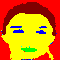

Learning rate:  0.0003023999999999999
Loss = tensor(1.3885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4258, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3741, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4026, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  135


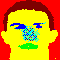

Learning rate:  0.0003023999999999999
Loss = tensor(1.3768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3787, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  135


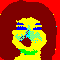

Learning rate:  0.0003023999999999999
Loss = tensor(1.4156, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  136


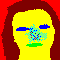

Learning rate:  0.0003023999999999999
Loss = tensor(1.4020, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  136


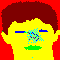

Learning rate:  0.0003023999999999999
Loss = tensor(1.4130, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3801, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  136


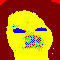

Learning rate:  0.0003023999999999999
Loss = tensor(1.4185, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  137


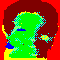

Learning rate:  0.0003023999999999999
Loss = tensor(1.3934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4182, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  137


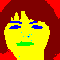

Learning rate:  0.0003023999999999999
Loss = tensor(1.3972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3791, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3936, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  137


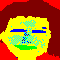

Learning rate:  0.0003023999999999999
Loss = tensor(1.4268, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  138


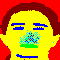

Learning rate:  0.0003023999999999999
Loss = tensor(1.4303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3737, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  138


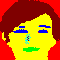

Learning rate:  0.0003023999999999999
Loss = tensor(1.3878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4059, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4096, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4156, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  138


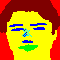

Learning rate:  0.0003023999999999999
Loss = tensor(1.3776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4163, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  139


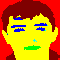

Learning rate:  0.0003023999999999999
Loss = tensor(1.4277, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  139


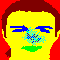

Learning rate:  0.0003023999999999999
Loss = tensor(1.3850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4233, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  139


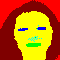

Learning rate:  0.0003023999999999999
Loss = tensor(1.3803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  140


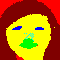

Learning rate:  0.0003023999999999999
Loss = tensor(1.3868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4031, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4102, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  140


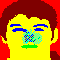

Learning rate:  0.0003023999999999999
Loss = tensor(1.4022, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3679, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4045, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  140


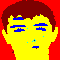

Learning rate:  0.0003023999999999999
Loss = tensor(1.3734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  141


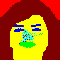

Learning rate:  0.0003023999999999999
Loss = tensor(1.3739, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  141


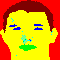

Learning rate:  0.0003023999999999999
Loss = tensor(1.3959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4072, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  141


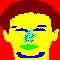

Learning rate:  0.0003023999999999999
Loss = tensor(1.4331, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4009, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  142


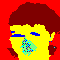

Learning rate:  0.0003023999999999999
Loss = tensor(1.3850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  142


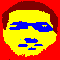

Learning rate:  0.0003023999999999999
Loss = tensor(1.3871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3837, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  142


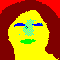

Learning rate:  0.0003023999999999999
Loss = tensor(1.4066, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  143


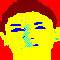

Learning rate:  0.0003023999999999999
Loss = tensor(1.3977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4180, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  143


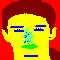

Learning rate:  0.0003023999999999999
Loss = tensor(1.4039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3881, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  143


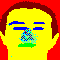

Learning rate:  0.0003023999999999999
Loss = tensor(1.3911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  144


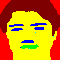

Learning rate:  0.0003023999999999999
Loss = tensor(1.4356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  144


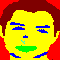

Learning rate:  0.0003023999999999999
Loss = tensor(1.3764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4113, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  144


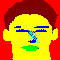

Learning rate:  0.0003023999999999999
Loss = tensor(1.4167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  145


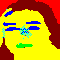

Learning rate:  0.0003023999999999999
Loss = tensor(1.4155, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4071, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4267, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3689, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  145


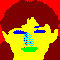

Learning rate:  0.0003023999999999999
Loss = tensor(1.3919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4155, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  145


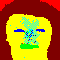

Learning rate:  0.0003023999999999999
Loss = tensor(1.3767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4164, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  146


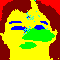

Learning rate:  0.0003023999999999999
Loss = tensor(1.3825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4296, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  146


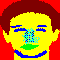

Learning rate:  0.0003023999999999999
Loss = tensor(1.4089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4015, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3845, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4115, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  146


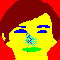

Learning rate:  0.0003023999999999999
Loss = tensor(1.3869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  147


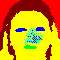

Learning rate:  0.0003023999999999999
Loss = tensor(1.3928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4164, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3855, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  147


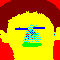

Learning rate:  0.0003023999999999999
Loss = tensor(1.3873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4236, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3898, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3877, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  147


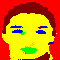

Learning rate:  0.0003023999999999999
Loss = tensor(1.4372, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4278, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  148


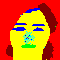

Learning rate:  0.0003023999999999999
Loss = tensor(1.4146, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4125, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4052, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4398, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  148


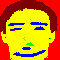

Learning rate:  0.0003023999999999999
Loss = tensor(1.3829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3784, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  148


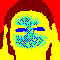

Learning rate:  0.0003023999999999999
Loss = tensor(1.4001, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4078, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  149


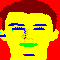

Learning rate:  0.0003023999999999999
Loss = tensor(1.3964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4090, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  149


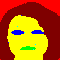

Learning rate:  0.0003023999999999999
Loss = tensor(1.4431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4159, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  149


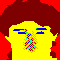

Learning rate:  0.0003023999999999999
Loss = tensor(1.3860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  150


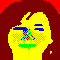

Learning rate:  0.0003023999999999999
Loss = tensor(1.3914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3700, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4100, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  150


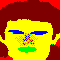

Learning rate:  0.0003023999999999999
Loss = tensor(1.4221, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4097, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4093, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3607, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  150


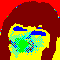

Learning rate:  0.0003023999999999999
Loss = tensor(1.4030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4008, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  151


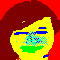

Learning rate:  0.0003023999999999999
Loss = tensor(1.4021, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  151


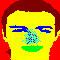

Learning rate:  0.0003023999999999999
Loss = tensor(1.4131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3761, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4164, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  151


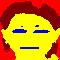

Learning rate:  0.0003023999999999999
Loss = tensor(1.3937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  152


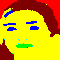

Learning rate:  0.0003023999999999999
Loss = tensor(1.3837, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4049, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  152


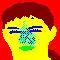

Learning rate:  0.0003023999999999999
Loss = tensor(1.3765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  152


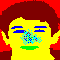

Learning rate:  0.0003023999999999999
Loss = tensor(1.3767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3963, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  153


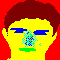

Learning rate:  0.0003023999999999999
Loss = tensor(1.4064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4184, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  153


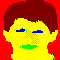

Learning rate:  0.0003023999999999999
Loss = tensor(1.3950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  153


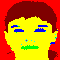

Learning rate:  0.0003023999999999999
Loss = tensor(1.4177, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  154


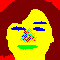

Learning rate:  0.0003023999999999999
Loss = tensor(1.3997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4159, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3998, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  154


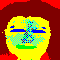

Learning rate:  0.0003023999999999999
Loss = tensor(1.3850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4006, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  154


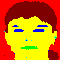

Learning rate:  0.0003023999999999999
Loss = tensor(1.3872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  155


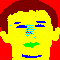

Learning rate:  0.0003023999999999999
Loss = tensor(1.3952, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4003, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4320, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3874, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  155


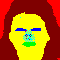

Learning rate:  0.0003023999999999999
Loss = tensor(1.3716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  155


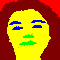

Learning rate:  0.0003023999999999999
Loss = tensor(1.4079, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4008, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  156


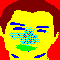

Learning rate:  0.0003023999999999999
Loss = tensor(1.3599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4110, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4107, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  156


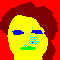

Learning rate:  0.0003023999999999999
Loss = tensor(1.4228, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3947, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  156


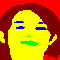

Learning rate:  0.0003023999999999999
Loss = tensor(1.3967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4097, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  157


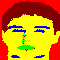

Learning rate:  0.0003023999999999999
Loss = tensor(1.3932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  157


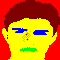

Learning rate:  0.0003023999999999999
Loss = tensor(1.4021, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3766, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  157


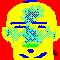

Learning rate:  0.0003023999999999999
Loss = tensor(1.3845, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4220, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  158


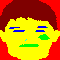

Learning rate:  0.0003023999999999999
Loss = tensor(1.4015, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3894, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4012, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  158


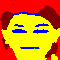

Learning rate:  0.0003023999999999999
Loss = tensor(1.3973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4156, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4336, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  158


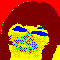

Learning rate:  0.0003023999999999999
Loss = tensor(1.4067, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  159


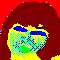

Learning rate:  0.0003023999999999999
Loss = tensor(1.4022, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3991, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  159


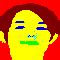

Learning rate:  0.0003023999999999999
Loss = tensor(1.4023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4243, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  159


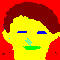

Learning rate:  0.0003023999999999999
Loss = tensor(1.3924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  160


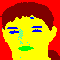

Learning rate:  0.0003023999999999999
Loss = tensor(1.4200, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3737, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4419, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4272, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  160


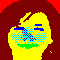

Learning rate:  0.0003023999999999999
Loss = tensor(1.3835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4125, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  160


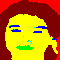

Learning rate:  0.0003023999999999999
Loss = tensor(1.4041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  161


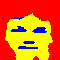

Learning rate:  0.0003023999999999999
Loss = tensor(1.3964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3908, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  161


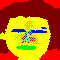

Learning rate:  0.0003023999999999999
Loss = tensor(1.3905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3844, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4267, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  161


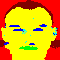

Learning rate:  0.0003023999999999999
Loss = tensor(1.4088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  162


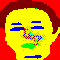

Learning rate:  0.0003023999999999999
Loss = tensor(1.4003, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3912, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  162


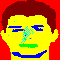

Learning rate:  0.0003023999999999999
Loss = tensor(1.3794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4133, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  162


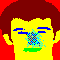

Learning rate:  0.0003023999999999999
Loss = tensor(1.4074, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  163


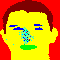

Learning rate:  0.0003023999999999999
Loss = tensor(1.3849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  163


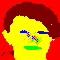

Learning rate:  0.0003023999999999999
Loss = tensor(1.3830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3864, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4453, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  163


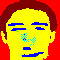

Learning rate:  0.0003023999999999999
Loss = tensor(1.3913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4134, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  164


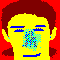

Learning rate:  0.0003023999999999999
Loss = tensor(1.3860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3844, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  164


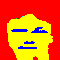

Learning rate:  0.0003023999999999999
Loss = tensor(1.3850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3766, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3929, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  164


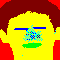

Learning rate:  0.0003023999999999999
Loss = tensor(1.3977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  165


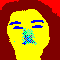

Learning rate:  0.0003023999999999999
Loss = tensor(1.4000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4294, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  165


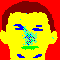

Learning rate:  0.0003023999999999999
Loss = tensor(1.4094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3775, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  165


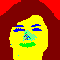

Learning rate:  0.0003023999999999999
Loss = tensor(1.3808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  166


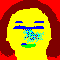

Learning rate:  0.0003023999999999999
Loss = tensor(1.3869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4072, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3998, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  166


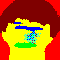

Learning rate:  0.0003023999999999999
Loss = tensor(1.4159, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4319, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3798, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  166


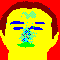

Learning rate:  0.0003023999999999999
Loss = tensor(1.3787, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  167


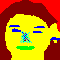

Learning rate:  0.0003023999999999999
Loss = tensor(1.3887, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3883, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  167


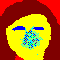

Learning rate:  0.0003023999999999999
Loss = tensor(1.4102, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4398, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  167


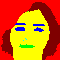

Learning rate:  0.0003023999999999999
Loss = tensor(1.3951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  168


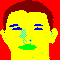

Learning rate:  0.0003023999999999999
Loss = tensor(1.3647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4071, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4380, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  168


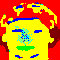

Learning rate:  0.0003023999999999999
Loss = tensor(1.4088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3929, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  168


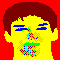

Learning rate:  0.0003023999999999999
Loss = tensor(1.3687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4011, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  169


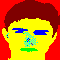

Learning rate:  0.0003023999999999999
Loss = tensor(1.4229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4219, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3853, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  169


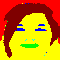

Learning rate:  0.0003023999999999999
Loss = tensor(1.4202, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3861, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  169


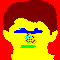

Learning rate:  0.0003023999999999999
Loss = tensor(1.3930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  170


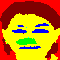

Learning rate:  0.0003023999999999999
Loss = tensor(1.3843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4298, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4015, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  170


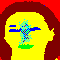

Learning rate:  0.0003023999999999999
Loss = tensor(1.3896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4103, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4160, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  170


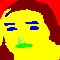

Learning rate:  0.0003023999999999999
Loss = tensor(1.3873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  171


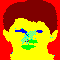

Learning rate:  0.0003023999999999999
Loss = tensor(1.3720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3933, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  171


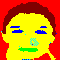

Learning rate:  0.0003023999999999999
Loss = tensor(1.3907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4015, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4302, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  171


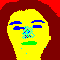

Learning rate:  0.0003023999999999999
Loss = tensor(1.3686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  172


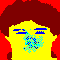

Learning rate:  0.0003023999999999999
Loss = tensor(1.3882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4070, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3874, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  172


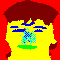

Learning rate:  0.0003023999999999999
Loss = tensor(1.4095, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4204, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  172


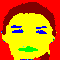

Learning rate:  0.0003023999999999999
Loss = tensor(1.4317, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  173


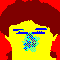

Learning rate:  0.0003023999999999999
Loss = tensor(1.3942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3740, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4252, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  173


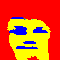

Learning rate:  0.0003023999999999999
Loss = tensor(1.4222, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  173


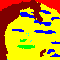

Learning rate:  0.0003023999999999999
Loss = tensor(1.4040, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  174


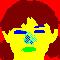

Learning rate:  0.0003023999999999999
Loss = tensor(1.4070, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3952, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  174


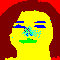

Learning rate:  0.0003023999999999999
Loss = tensor(1.3879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3891, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  174


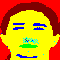

Learning rate:  0.0003023999999999999
Loss = tensor(1.4106, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  175


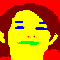

Learning rate:  0.0003023999999999999
Loss = tensor(1.3802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4004, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  175


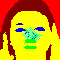

Learning rate:  0.0003023999999999999
Loss = tensor(1.4172, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  175


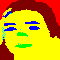

Learning rate:  0.0003023999999999999
Loss = tensor(1.3996, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  176


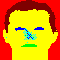

Learning rate:  0.0003023999999999999
Loss = tensor(1.4368, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4125, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  176


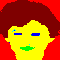

Learning rate:  0.0003023999999999999
Loss = tensor(1.4025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3991, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3989, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  176


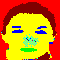

Learning rate:  0.0003023999999999999
Loss = tensor(1.3947, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4136, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  177


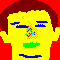

Learning rate:  0.0003023999999999999
Loss = tensor(1.3937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3961, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  177


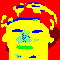

Learning rate:  0.0003023999999999999
Loss = tensor(1.4110, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4243, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  177


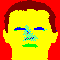

Learning rate:  0.0003023999999999999
Loss = tensor(1.3705, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  178


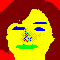

Learning rate:  0.0003023999999999999
Loss = tensor(1.4112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  178


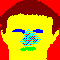

Learning rate:  0.0003023999999999999
Loss = tensor(1.4423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3844, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3976, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  178


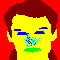

Learning rate:  0.0003023999999999999
Loss = tensor(1.4000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  179


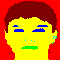

Learning rate:  0.0003023999999999999
Loss = tensor(1.3901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4243, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3908, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3898, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  179


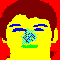

Learning rate:  0.0003023999999999999
Loss = tensor(1.3756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4132, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  179


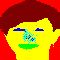

Learning rate:  0.0003023999999999999
Loss = tensor(1.3934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  180


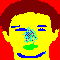

Learning rate:  0.0003023999999999999
Loss = tensor(1.4329, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4272, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3883, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  180


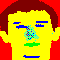

Learning rate:  0.0003023999999999999
Loss = tensor(1.3993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3952, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3800, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  180


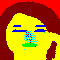

Learning rate:  0.0003023999999999999
Loss = tensor(1.3814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4207, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  181


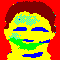

Learning rate:  0.0003023999999999999
Loss = tensor(1.3735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  181


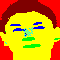

Learning rate:  0.0003023999999999999
Loss = tensor(1.4132, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4116, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  181


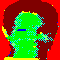

Learning rate:  0.0003023999999999999
Loss = tensor(1.4021, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4394, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  182


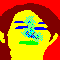

Learning rate:  0.0003023999999999999
Loss = tensor(1.3923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3864, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  182


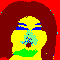

Learning rate:  0.0003023999999999999
Loss = tensor(1.3930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4109, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4047, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  182


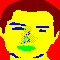

Learning rate:  0.0003023999999999999
Loss = tensor(1.4033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  183


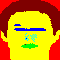

Learning rate:  0.0003023999999999999
Loss = tensor(1.3999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4228, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  183


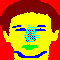

Learning rate:  0.0003023999999999999
Loss = tensor(1.3977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4242, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  183


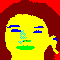

Learning rate:  0.0003023999999999999
Loss = tensor(1.3799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  184


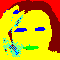

Learning rate:  0.0003023999999999999
Loss = tensor(1.4057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4451, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  184


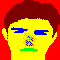

Learning rate:  0.0003023999999999999
Loss = tensor(1.3761, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  184


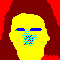

Learning rate:  0.0003023999999999999
Loss = tensor(1.4175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3963, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  185


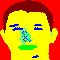

Learning rate:  0.0003023999999999999
Loss = tensor(1.3855, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4090, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4159, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  185


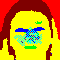

Learning rate:  0.0003023999999999999
Loss = tensor(1.3664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4252, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4252, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4429, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3952, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  185


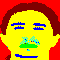

Learning rate:  0.0003023999999999999
Loss = tensor(1.3848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  186


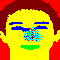

Learning rate:  0.0003023999999999999
Loss = tensor(1.4217, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3908, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3761, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3757, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  186


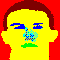

Learning rate:  0.0003023999999999999
Loss = tensor(1.3969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4204, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  186


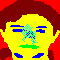

Learning rate:  0.0003023999999999999
Loss = tensor(1.3964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  187


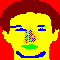

Learning rate:  0.0003023999999999999
Loss = tensor(1.3930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4295, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3761, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  187


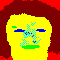

Learning rate:  0.0003023999999999999
Loss = tensor(1.3771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4243, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  187


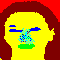

Learning rate:  0.0003023999999999999
Loss = tensor(1.3938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4195, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  188


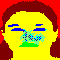

Learning rate:  0.0003023999999999999
Loss = tensor(1.4340, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3741, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  188


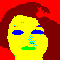

Learning rate:  0.0003023999999999999
Loss = tensor(1.3784, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3877, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4138, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  188


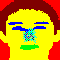

Learning rate:  0.0003023999999999999
Loss = tensor(1.3887, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3801, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  189


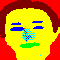

Learning rate:  0.0003023999999999999
Loss = tensor(1.3956, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3791, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4283, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  189


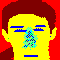

Learning rate:  0.0003023999999999999
Loss = tensor(1.3913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4020, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3998, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4022, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  189


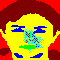

Learning rate:  0.0003023999999999999
Loss = tensor(1.4203, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3772, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  190


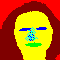

Learning rate:  0.0003023999999999999
Loss = tensor(1.3921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4158, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4220, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4143, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  190


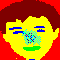

Learning rate:  0.0003023999999999999
Loss = tensor(1.3803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4155, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4217, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  190


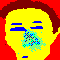

Learning rate:  0.0003023999999999999
Loss = tensor(1.4154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  191


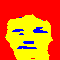

Learning rate:  0.0003023999999999999
Loss = tensor(1.3774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4118, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  191


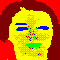

Learning rate:  0.0003023999999999999
Loss = tensor(1.4177, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4040, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3630, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3966, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  191


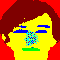

Learning rate:  0.0003023999999999999
Loss = tensor(1.3904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4132, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  192


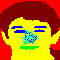

Learning rate:  0.0003023999999999999
Loss = tensor(1.3985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4164, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3881, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3864, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  192


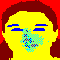

Learning rate:  0.0003023999999999999
Loss = tensor(1.4013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4109, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  192


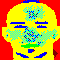

Learning rate:  0.0003023999999999999
Loss = tensor(1.3617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  193


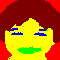

Learning rate:  0.0003023999999999999
Loss = tensor(1.3901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4008, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3898, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  193


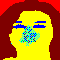

Learning rate:  0.0003023999999999999
Loss = tensor(1.3677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4493, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4138, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  193


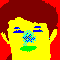

Learning rate:  0.0003023999999999999
Loss = tensor(1.3843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4288, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  194


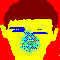

Learning rate:  0.0003023999999999999
Loss = tensor(1.4371, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4026, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  194


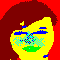

Learning rate:  0.0003023999999999999
Loss = tensor(1.3654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4067, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4171, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  194


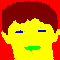

Learning rate:  0.0003023999999999999
Loss = tensor(1.3762, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  195


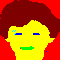

Learning rate:  0.0003023999999999999
Loss = tensor(1.4021, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3918, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  195


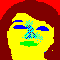

Learning rate:  0.0003023999999999999
Loss = tensor(1.3909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3912, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  195


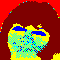

Learning rate:  0.0003023999999999999
Loss = tensor(1.3998, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3861, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  196


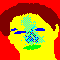

Learning rate:  0.0003023999999999999
Loss = tensor(1.3829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3864, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4143, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4060, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  196


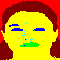

Learning rate:  0.0003023999999999999
Loss = tensor(1.4509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4141, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4070, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3995, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  196


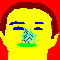

Learning rate:  0.0003023999999999999
Loss = tensor(1.4212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  197


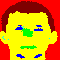

Learning rate:  0.0003023999999999999
Loss = tensor(1.4006, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4605, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3955, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4069, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  197


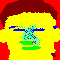

Learning rate:  0.0003023999999999999
Loss = tensor(1.3810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  197


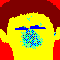

Learning rate:  0.0003023999999999999
Loss = tensor(1.3974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3755, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  198


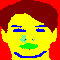

Learning rate:  0.0003023999999999999
Loss = tensor(1.3913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4016, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4074, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  198


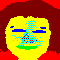

Learning rate:  0.0003023999999999999
Loss = tensor(1.3935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4177, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4127, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  198


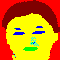

Learning rate:  0.0003023999999999999
Loss = tensor(1.3994, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  199


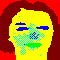

Learning rate:  0.0003023999999999999
Loss = tensor(1.3920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4233, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  199


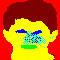

Learning rate:  0.0003023999999999999
Loss = tensor(1.4087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4097, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  199


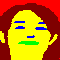

Learning rate:  0.0003023999999999999
Loss = tensor(1.3874, device='cuda:0', grad_fn=<NllLoss2DBackward>)


In [20]:
for epoch in range(epochs):
    i = 0
    last = False
    if epoch == epochs:
        last = True
    for batch in train_loader_CE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)
            
        b = get_rgb(x)
        #out = loss1(b,c) + 4*loss1(b[3],c[3])+15*loss1(b[4],c[4])+4*loss1(b[5],c[5])
        out = loss2(b, targets.detach().long())
        print("Loss =", out)
        loss_ce.append(float(out))
        c = b.detach().clone()
        
        if (i % 5 == 0):
            print("EPOCH: ", epoch)
            display(ts(max_rgb(c)[0]))
            print("Learning rate: ", scheduler.get_last_lr()[0])
            del c
        i += 1
        
        optimizer.zero_grad()
        out.backward()
        optimizer.step()
    scheduler.step()

In [18]:
torch.save(model, 'misc_figures/collabAlt.pth')

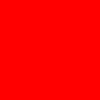

In [26]:
from IPython.display import display, Image
Image('final.gif')

In [ ]:
plt.plot(loss_mse)

In [31]:
torch.argmax(get_rgb(x), dim=1).flatten(1,2).shape

torch.Size([5, 4900])

torch.Size([60, 60, 4])


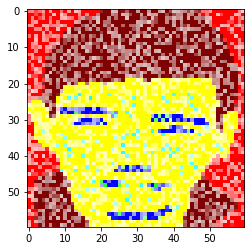

In [23]:
# Show certainty of pixels

a = max_rgba(b[0]).detach().clone().to('cpu')
plt.imshow(a.transpose(1,2).transpose(0,2))
plt.show()

In [39]:
# Save final iterations as gif

epoch_new = [ts(i) for i in epoch_history]
epoch_new[0].save('anitest.gif',
               save_all=True,
               append_images=epoch_new[1:],
               duration=1000,
               loop=0)

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mutual_info_score 
from sklearn.metrics import ConfusionMatrixDisplay

# DICE Score
def dice(pred, truth, epsilon=1e-6):
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()

    x = confusion_matrix(pred, target)
    
    FP = x.sum(axis=0) - np.diag(x)
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    FP = np.sum(FP)
    FN = np.sum(FN)
    TP = np.sum(TP)
    TN = np.sum(TN)
    
    d5 = 2*TP+FN+FP
    if d5 == 0:
        d5 = epsilon
    dice = 2*TP/d5
    
    return dice    

# Precision, Recall, Accuracy and Specificity Score
def pras(pred, truth):
    
    # Convert to format for confusion matrix
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()

    x = confusion_matrix(pred, target)

    # Calculate FP, FN, TP, TN
    FP = x.sum(axis=0) - np.diag(x)
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    # Set the denominators and deal with 0 denominators
    d1 = TP+FP
    d1[np.where(d1==0)] = -1
    d2 = TP+FN
    d2[np.where(d2==0)] = -1
    d3 = TP+TN+FP+FN
    d3[np.where(d3==0)] = -1
    d4 = TN+FP
    d4[np.where(d4==0)] = -1

    # Calculate and return scores
    precision = TP/d1
    recall = TP/d2
    accuracy = (TP+TN)/d3
    specificity = TN/d4
    
    return precision, recall, accuracy, specificity

# Recall Score
def overall_pras(pred, truth):
    
    # Convert to format for confusion matrix
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()
    
    x = confusion_matrix(pred, target)

    FP = x.sum(axis=0) - np.diag(x)  
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    # Sum the values for overall values
    FP = np.sum(FP)
    FN = np.sum(FN)
    TP = np.sum(TP)
    TN = np.sum(TN)
    
    # Set the denominators and deal with 0 denominators
    d1 = TP+FP
    d2 = TP+FN
    d3 = TP+TN+FP+FN
    d4 = TN+FP
    
    # Calculate and return scores and deal with potential 0 denominators
    if d1 > 0:
        precision = TP/d1
    else:
        precision = -1
        
    if d2 > 0:
        recall = TP/d2
    else:
        recall = -1
    
    if d3 > 0:
        accuracy = (TP+TN)/d3
    else:
        d3 = -1
        
    if d4 > 0:
        specificity = TN/d4
    else:
        specificity = -1
    
    return precision, recall, accuracy, specificity

# Mutual Information
def mi(pred, target):
    print(pred.squeeze().shape)
    print(target.flatten().shape)
    return mutual_info_score(pred.flatten().cpu(), target.flatten().cpu())

def get_confusion(pred, target):
    pred = pred.view(-1).cpu()
    target = target.view(-1).cpu()
    x = confusion_matrix(pred.cpu(), target.cpu())
    return x

def print_confusion(conf):
    xt = ["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"]
    sns.set(font_scale=1.4, rc={'figure.figsize':(11.7,8.27)}) 
    sns.heatmap(conf, annot=True, annot_kws={"size": 16}, fmt='g', xticklabels=xt, yticklabels=xt)
    plt.savefig("confusion.png")

In [23]:
# Empty lists for precision, recall, accuracy, specificity, DICE

po_list = []
ro_list = []
ao_list = []
so_list = []

p_list = []
r_list = []
a_list = []
s_list = []

dice_list = []
mi_list = []

Loss = tensor(1.4434, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


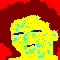

1.4434159994125366
Loss = tensor(1.4830, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


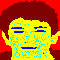

1.483046054840088
Loss = tensor(1.4615, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


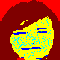

1.461500644683838
Loss = tensor(1.4737, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


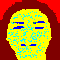

1.4736582040786743
Loss = tensor(1.4725, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


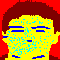

1.472463607788086
Loss = tensor(1.4721, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


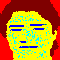

1.4721477031707764
Loss = tensor(1.4393, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


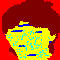

1.4393020868301392
Loss = tensor(1.5623, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


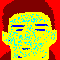

1.5623246431350708
Loss = tensor(1.4648, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


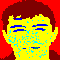

1.4647880792617798
Loss = tensor(1.4724, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


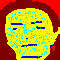

1.472388744354248
Loss = tensor(1.4300, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


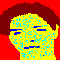

1.4299877882003784
Loss = tensor(1.4303, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


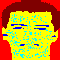

1.4303048849105835
Loss = tensor(1.4742, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


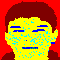

1.4741610288619995
Loss = tensor(1.4430, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


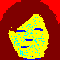

1.4429677724838257
Loss = tensor(1.4265, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


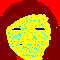

1.4265433549880981
Loss = tensor(1.4783, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


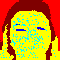

1.4782695770263672
Loss = tensor(1.4762, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


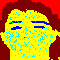

1.476176381111145
Loss = tensor(1.4873, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


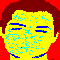

1.4873216152191162
Loss = tensor(1.4255, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


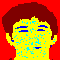

1.4254950284957886
Loss = tensor(1.4424, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


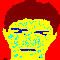

1.4424443244934082
Loss = tensor(1.5755, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


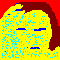

1.5755252838134766
Loss = tensor(1.4637, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


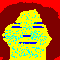

1.4637104272842407
Loss = tensor(1.4446, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


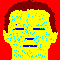

1.444594383239746
Loss = tensor(1.4387, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


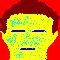

1.4386504888534546
Loss = tensor(1.5058, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


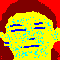

1.5057792663574219
Loss = tensor(1.4747, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


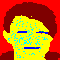

1.4747040271759033
Loss = tensor(1.4409, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


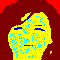

1.4409455060958862
Loss = tensor(1.4480, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


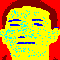

1.4479649066925049
Loss = tensor(1.4285, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


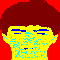

1.4284896850585938
Loss = tensor(1.5130, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


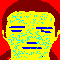

1.5129956007003784


In [24]:
# Inference and test loss
loss_test_ce = []
batch_size=1
conf_running = torch.zeros(6,6)

with torch.no_grad():
    for batch in test_loader_CE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)

        b = get_rgb(x)
        pred = torch.argmax(b, dim=1)
        out = loss2(b, targets.detach().long())
        print("Loss =", out)
        loss_test_ce.append(float(out))
        c = b.detach().clone()
        
        target = targets.detach().long()
        
        # Log metrics
        p,r,a,s = overall_pras(pred, target)
        po_list.append(p)
        ro_list.append(r)
        ao_list.append(a)
        so_list.append(s)
        
        d = dice(pred, target)
        dice_list.append(d.item())
        
        m = mi(pred, target)
        mi_list.append(m)
        
        p,r,a,s = pras(pred, target)
        p_list.append(p)
        r_list.append(r)
        a_list.append(a)
        s_list.append(s)
        
        conf_running += get_confusion(pred, target)
        
        for i in range(batch_size):
            display(ts(max_rgb(c)[i]))
        del c
        print(float(out))

In [26]:
boxplot_p = np.array(p_list)
boxplot_r = np.array(r_list)
boxplot_a = np.array(a_list)
boxplot_s = np.array(s_list)
boxplot_mi = np.array(mi_list)

np.save('metrics/collab_p.npy', boxplot_p)
np.save('metrics/collab_r.npy', boxplot_r)
np.save('metrics/collab_a.npy', boxplot_a)
np.save('metrics/collab_s.npy', boxplot_s)
np.save('metrics/collab_m.npy', boxplot_mi)
np.save('metrics/collab_dice.npy', dice_list)

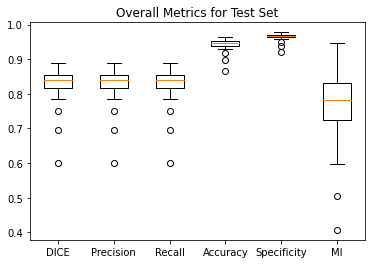

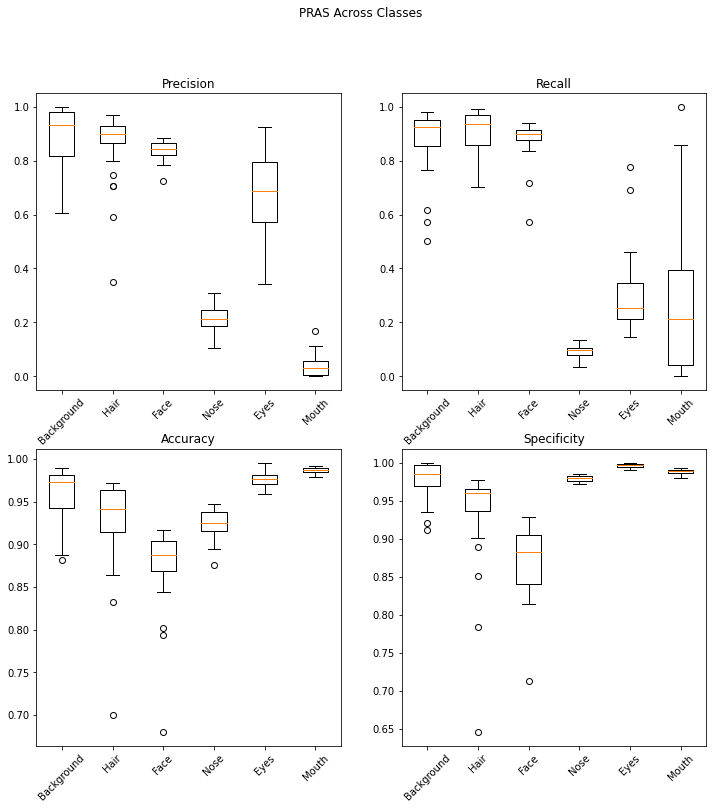

In [27]:
pras_overall_list = [dice_list, po_list, ro_list, ao_list, so_list, mi_list]
#sns.boxplot(x=np.array(pras_overall_list), y=np.array([1,2,3,4]))
plt.boxplot(pras_overall_list)
plt.xticks([1,2,3,4,5,6],["DICE", "Precision", "Recall", "Accuracy", "Specificity", "MI"])
plt.title("Overall Metrics for Test Set")
plt.savefig("1CollabAltPras.png")


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
ax1.boxplot(boxplot_p)
ax1.set_title("Precision")
ax1.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax2.boxplot(boxplot_r)
ax2.set_title("Recall")
ax2.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax3.boxplot(boxplot_a)
ax3.set_title("Accuracy")
ax3.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax4.boxplot(boxplot_s)
ax4.set_title("Specificity")
ax4.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

fig.set_figwidth(12)
fig.set_figheight(12)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
fig.suptitle('PRAS Across Classes')

plt.savefig("pras/1CollabAltPrasClass.png")

In [46]:
np.save('1dice_collabAlt.npy', dice_list)

In [47]:
np.save('1dice_collabRand.npy', rand_dice)

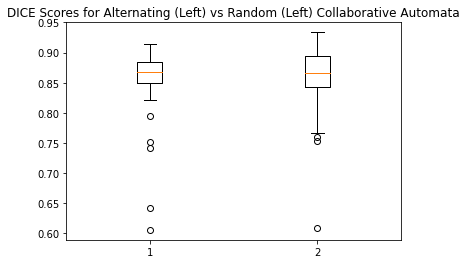

In [58]:
d1 = np.load('1dice_collabAlt.npy')
d2 = rand_dice
plt.boxplot([d1, d2])
plt.title("DICE Scores for Alternating (Left) vs Random (Left) Collaborative Automata")
plt.savefig("collabvs.png")

In [59]:
d1 = np.load('1dice_collabAlt.npy')
d2 = rand_dice

In [60]:
sum(d1)/len(d1)

0.8467962962962965

In [61]:
sum(d2)/len(d2)

0.8547235545247985